# Analysis

This notebook analyzes the relationship between mathematical complexity and paper acceptance rates in major machine learning conferences (ICLR and NeurIPS). We explore this relationship through statistical analysis and machine learning approaches.

## Setup


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import shap
import lime.lime_tabular
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import xgboost as xgb
from scipy.stats import f_oneway
from sklearn.inspection import permutation_importance
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
import warnings
warnings.simplefilter("ignore")

# Define common feature names
FEATURE_NAMES = [
    "num_equations",
    "mean_num_new_symbols_introduced",
    "num_overall_unique_symbols",
    "mean_num_unique_symbols",
    "std_of_unique_symbols",
    "max_representational_complexity"
]

# Load datasets
iclr = pd.read_csv("../feature_extraction/iclr.csv", index_col=False)
neurips = pd.read_csv("../feature_extraction/neurips.csv", index_col=False)

# Initial preprocessing
iclr = iclr[iclr.status != "Desk Reject"]
iclr = iclr[iclr.status != "Withdraw"]
iclr.dropna(axis="index")
iclr.reset_index(drop=True, inplace=True)

neurips.dropna(axis="index")
neurips.reset_index(drop=True, inplace=True)

print("ICLR dataset shape:", iclr.shape)
print("NeurIPS dataset shape:", neurips.shape)

ICLR dataset shape: (957, 15)
NeurIPS dataset shape: (2920, 15)


/home/linus/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing and Feature Analysis

We begin by preparing our data and defining our features of interest. For ICLR papers, we classify papers as accepted (including Poster, Top-25%, and Top-5%) or rejected.

In [2]:
def get_binary_labels(status, conference):
    """Convert conference status to binary labels."""
    status = np.array(status)
    if conference.lower() == 'iclr':
        accept_categories = ["Top-25%", "Top-5%", "Poster"]
    else:  # neurips
        accept_categories = ["Poster", "Spotlight", "Oral"]
    
    return np.where(np.isin(status, accept_categories), 1, 0)

# Process ICLR data
iclr_labels = get_binary_labels(iclr.status, 'iclr')
iclr_features = iclr[FEATURE_NAMES]

# Process NeurIPS data
neurips_labels = get_binary_labels(neurips.status, 'neurips')
neurips_features = neurips[FEATURE_NAMES]

print("ICLR acceptance rate: {:.2f}%".format(100 * np.mean(iclr_labels)))
print("NeurIPS acceptance rate: {:.2f}%".format(100 * np.mean(neurips_labels)))

ICLR acceptance rate: 54.55%
NeurIPS acceptance rate: 94.90%


## Correlation Analysis

We first examine the correlation between each feature and paper acceptance status for ICLR papers. This gives us an initial understanding of which mathematical complexity features might be most relevant to acceptance decisions.


ICLR Feature Correlation Matrix:

Correlation Matrix Values:
-------------------------
num_equations   1.000 -0.555 0.643 0.165 0.131 0.301
mean_num_new_symbols_introduced -0.555 1.000 -0.360 0.057 0.097 -0.160
num_overall_unique_symbols 0.643 -0.360 1.000 0.592 0.545 0.609
mean_num_unique_symbols 0.165 0.057 0.592 1.000 0.850 0.557
std_of_unique_symbols 0.131 0.097 0.545 0.850 1.000 0.741
max_representational_complexity 0.301 -0.160 0.609 0.557 0.741 1.000


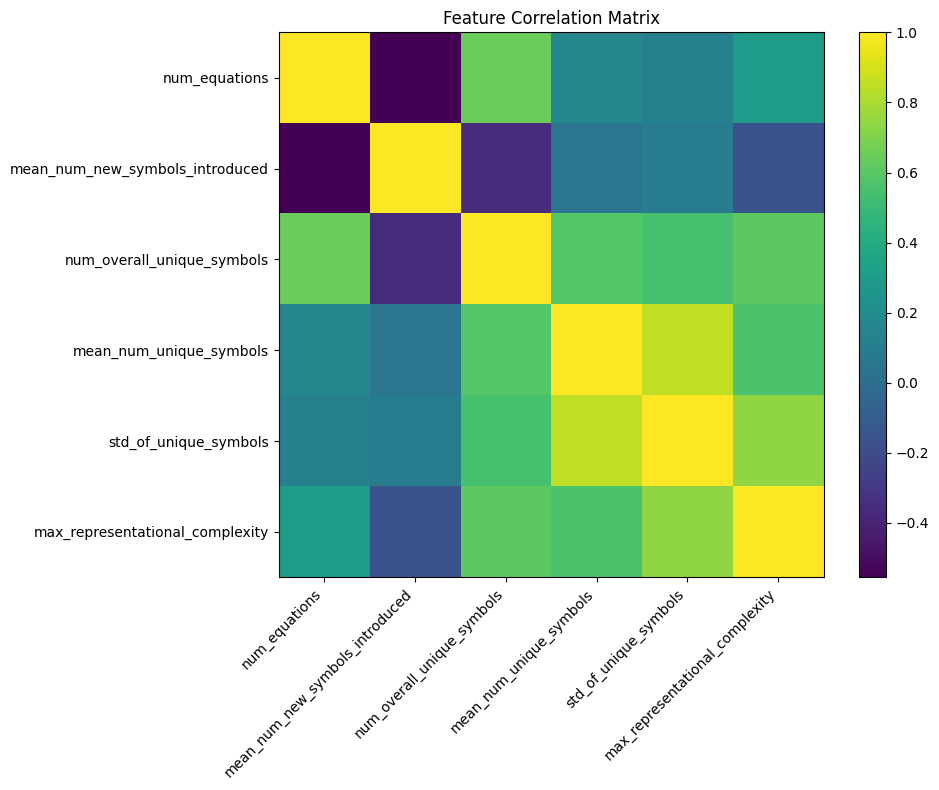


ICLR Feature Correlations with Acceptance:
----------------------------------------------------------------------
Feature                          Original     Oversampled    Undersampled
----------------------------------------------------------------------
num_equations                       0.134           0.127           0.141
num_overall_unique_symbols          0.128           0.149           0.132
mean_num_new_symbols_introduced     -0.125          -0.133          -0.121
mean_num_unique_symbols             0.101           0.089           0.101
std_of_unique_symbols               0.086           0.095           0.086
max_representational_complexity      0.055           0.081           0.054

NeurIPS Feature Correlation Matrix:

Correlation Matrix Values:
-------------------------
num_equations   1.000 -0.204 0.706 0.153 0.168 0.396
mean_num_new_symbols_introduced -0.204 1.000 -0.171 0.412 -0.037 -0.070
num_overall_unique_symbols 0.706 -0.171 1.000 0.471 0.537 0.659
mean_num_uniqu

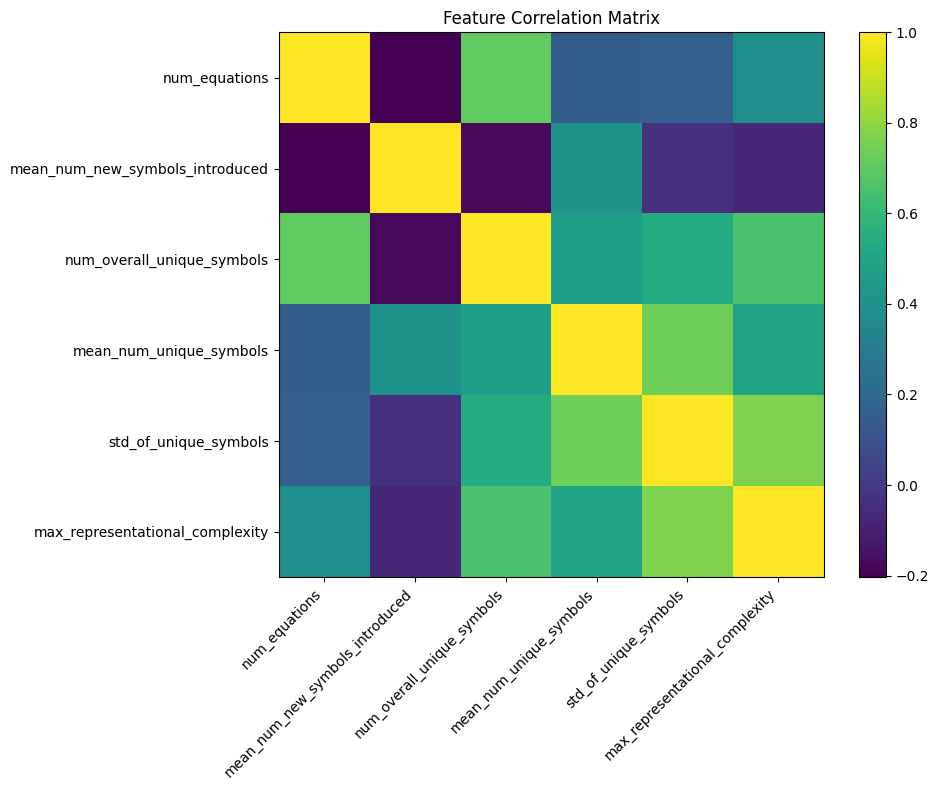


NeurIPS Feature Correlations with Acceptance:
----------------------------------------------------------------------
Feature                          Original     Oversampled    Undersampled
----------------------------------------------------------------------
mean_num_unique_symbols            -0.015          -0.044          -0.135
num_equations                       0.014           0.021           0.004
std_of_unique_symbols              -0.009          -0.035          -0.110
max_representational_complexity     -0.003          -0.028          -0.061
num_overall_unique_symbols         -0.001          -0.017          -0.094
mean_num_new_symbols_introduced      0.000           0.006          -0.064


In [3]:
from sklearn.utils import resample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_correlations(data, features, labels):
    """Calculate correlations between features and acceptance status."""
    correlations = []
    for feature in features:
        corr = np.corrcoef(data[feature], labels)[0, 1]
        correlations.append((feature, corr))
    return correlations

def calculate_correlations_with_sampling(features, labels, sampling_strategy='over'):
    """
    Calculate correlations with balanced sampling.
    
    Parameters:
    - features: DataFrame of features
    - labels: Array of binary labels
    - sampling_strategy: 'over' for oversampling minority class
                        'under' for undersampling majority class
    """
    # Combine features and labels
    data = features.copy()
    data['label'] = labels
    
    # Separate majority and minority classes
    majority_class = data[data.label == data.label.mode()[0]]
    minority_class = data[data.label != data.label.mode()[0]]
    
    if sampling_strategy == 'over':
        # Oversample minority class
        minority_upsampled = resample(minority_class,
                                    replace=True,
                                    n_samples=len(majority_class),
                                    random_state=42)
        balanced_data = pd.concat([majority_class, minority_upsampled])
    else:
        # Undersample majority class
        majority_downsampled = resample(majority_class,
                                      replace=False,
                                      n_samples=len(minority_class),
                                      random_state=42)
        balanced_data = pd.concat([majority_downsampled, minority_class])
    
    # Calculate correlations with balanced dataset
    correlations = []
    for feature in FEATURE_NAMES:
        corr = np.corrcoef(balanced_data[feature], balanced_data.label)[0, 1]
        correlations.append((feature, corr))
    
    return correlations

def plot_correlation_matrix(features):
    """Calculate and visualize the correlation matrix between features."""
    corr_matrix = np.zeros((len(FEATURE_NAMES), len(FEATURE_NAMES)))
    for i, name in enumerate(FEATURE_NAMES):
        for j, other_name in enumerate(FEATURE_NAMES):
            corr_matrix[i, j] = np.corrcoef(features[name], features[other_name])[0, 1]
    
    # Print correlation matrix values
    print("\nCorrelation Matrix Values:")
    print("-------------------------")
    for i, name in enumerate(FEATURE_NAMES):
        row_values = [f"{corr_matrix[i, j]:.3f}" for j in range(len(FEATURE_NAMES))]
        print(f"{name:15} {' '.join(row_values)}")
    
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix)
    plt.colorbar()
    plt.xticks(range(len(FEATURE_NAMES)), FEATURE_NAMES, rotation=45, ha='right')
    plt.yticks(range(len(FEATURE_NAMES)), FEATURE_NAMES)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# Calculate and display correlations for both conferences
for conf_name, features, labels in [('ICLR', iclr_features, iclr_labels),
                                  ('NeurIPS', neurips_features, neurips_labels)]:
    # Plot feature correlation matrix
    print(f"\n{conf_name} Feature Correlation Matrix:")
    corr_matrix = plot_correlation_matrix(features)
    
    # Calculate and display correlations with acceptance (original and balanced)
    print(f"\n{conf_name} Feature Correlations with Acceptance:")
    print("-" * 70)
    print(f"{'Feature':30} {'Original':>10} {'Oversampled':>15} {'Undersampled':>15}")
    print("-" * 70)
    
    # Get correlations for all three approaches
    original_correlations = calculate_correlations(features, FEATURE_NAMES, labels)
    over_correlations = calculate_correlations_with_sampling(features, labels, 'over')
    under_correlations = calculate_correlations_with_sampling(features, labels, 'under')
    
    # Sort by absolute value of original correlation
    sorted_indices = [i for i, _ in sorted(enumerate(original_correlations), 
                                         key=lambda x: abs(x[1][1]), 
                                         reverse=True)]
    
    # Print comparative results
    for idx in sorted_indices:
        feature = FEATURE_NAMES[idx]
        print(f"{feature:30} {original_correlations[idx][1]:10.3f} "
              f"{over_correlations[idx][1]:15.3f} {under_correlations[idx][1]:15.3f}")

## Statistical Hypothesis Testing


ICLR Statistical Analysis
+---------------------------------+----------------------+---------------+-------------------------+-------------+----------+---------+--------+
| Feature                         | Sample Sizes (A/R)   | Means (A/R)   | Cohen's d [95% CI]      | Effect      | t-test   | Welch   | M-W    |
+=================================+======================+===============+=========================+=============+==========+=========+========+
| Num Equations                   | 522/435              | 547.55/424.94 | 0.271 [0.158, 0.392]    | small†      | 0.000*   | 0.000*  | 0.000* |
+---------------------------------+----------------------+---------------+-------------------------+-------------+----------+---------+--------+
| Mean Num New Symbols Introduced | 522/435              | 0.20/0.23     | -0.253 [-0.375, -0.124] | small†      | 0.000*   | 0.000*  | 0.000* |
+---------------------------------+----------------------+---------------+-------------------------+---

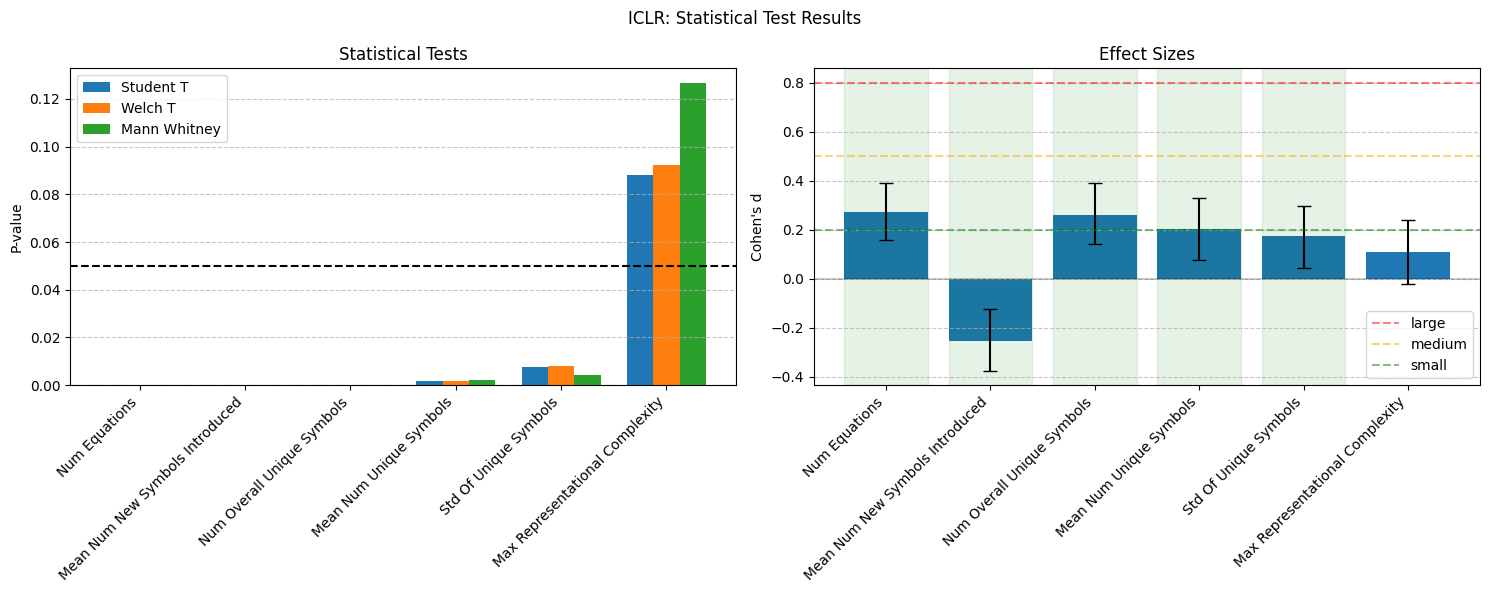


NeurIPS Statistical Analysis
+---------------------------------+----------------------+---------------+------------------------+------------+----------+---------+-------+
| Feature                         | Sample Sizes (A/R)   | Means (A/R)   | Cohen's d [95% CI]     | Effect     |   t-test |   Welch |   M-W |
+=================================+======================+===============+========================+============+==========+=========+=======+
| Num Equations                   | 2771/149             | 472.17/442.19 | 0.063 [-0.071, 0.193]  | negligible |    0.454 |   0.356 | 0.941 |
+---------------------------------+----------------------+---------------+------------------------+------------+----------+---------+-------+
| Mean Num New Symbols Introduced | 2771/149             | 0.27/0.27     | 0.000 [-0.175, 0.080]  | negligible |    0.996 |   0.991 | 0.971 |
+---------------------------------+----------------------+---------------+------------------------+------------+------

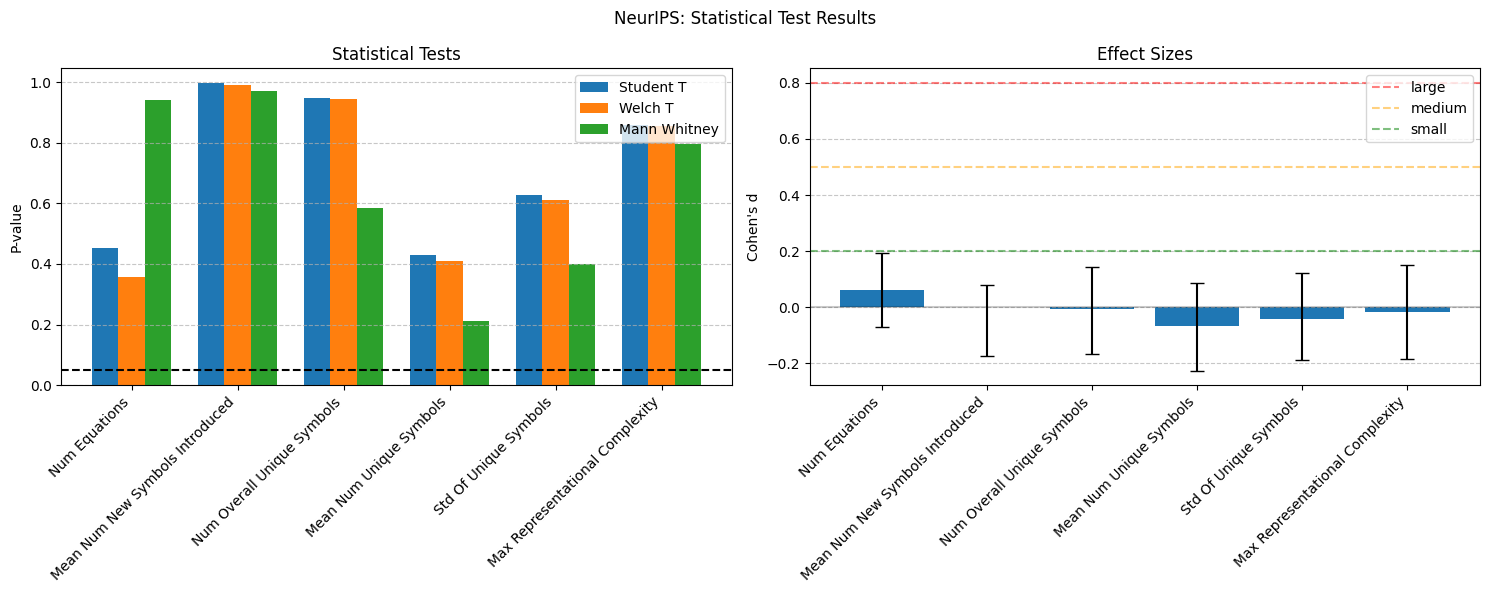

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tabulate import tabulate

def compare_means(sample1, sample2, feature_name, n_bootstrap=1000):
    """
    Perform comprehensive statistical comparison between two samples with
    bootstrap confidence intervals for effect sizes.
    
    Parameters:
    sample1, sample2: Arrays for accepted and rejected papers respectively
    feature_name: Name of the feature being analyzed
    n_bootstrap: Number of bootstrap iterations for confidence intervals
    
    Returns:
    Dictionary containing comprehensive statistical analysis results
    """
    # Calculate three different statistical tests to ensure robustness
    t_stat, t_pval = stats.ttest_ind(sample1, sample2)
    welch_stat, welch_pval = stats.ttest_ind(sample1, sample2, equal_var=False)
    mw_stat, mw_pval = stats.mannwhitneyu(sample1, sample2, alternative='two-sided')
    
    # Calculate effect size (Cohen's d) with pooled standard deviation
    pooled_std = np.sqrt((np.var(sample1, ddof=1) * (len(sample1) - 1) + 
                         np.var(sample2, ddof=1) * (len(sample2) - 1)) / 
                        (len(sample1) + len(sample2) - 2))
    cohens_d = (np.mean(sample1) - np.mean(sample2)) / pooled_std
    
    # Bootstrap confidence intervals for effect size
    bootstrap_effects = []
    for _ in range(n_bootstrap):
        boot_s1 = np.random.choice(sample1, size=len(sample1), replace=True)
        boot_s2 = np.random.choice(sample2, size=len(sample2), replace=True)
        
        boot_std = np.sqrt((np.var(boot_s1, ddof=1) * (len(boot_s1) - 1) + 
                          np.var(boot_s2, ddof=1) * (len(boot_s2) - 1)) / 
                         (len(boot_s1) + len(boot_s2) - 2))
        boot_effect = (np.mean(boot_s1) - np.mean(boot_s2)) / boot_std
        bootstrap_effects.append(boot_effect)
    
    ci_lower, ci_upper = np.percentile(bootstrap_effects, [2.5, 97.5])
    
    # Interpret effect size magnitude
    if abs(cohens_d) < 0.2:
        effect_magnitude = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_magnitude = "small"
    elif abs(cohens_d) < 0.8:
        effect_magnitude = "medium"
    else:
        effect_magnitude = "large"
    
    return {
        "feature": feature_name,
        "sample_sizes": {
            "accepted": len(sample1),
            "rejected": len(sample2)
        },
        "means": {
            "accepted": np.mean(sample1),
            "rejected": np.mean(sample2)
        },
        "effect_size": {
            "cohens_d": cohens_d,
            "magnitude": effect_magnitude,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper
        },
        "tests": {
            "student_t": {
                "statistic": t_stat,
                "p_value": t_pval,
                "significant": t_pval < 0.05
            },
            "welch_t": {
                "statistic": welch_stat,
                "p_value": welch_pval,
                "significant": welch_pval < 0.05
            },
            "mann_whitney": {
                "statistic": mw_stat,
                "p_value": mw_pval,
                "significant": mw_pval < 0.05
            }
        }
    }

def create_analysis_table(results):
    """
    Create a formatted table showing statistical analysis results with confidence intervals
    and effect stability indicators.
    """
    headers = [
        "Feature", "Sample Sizes (A/R)", "Means (A/R)",
        "Cohen's d [95% CI]", "Effect", "t-test", "Welch", "M-W"
    ]
    
    table_data = []
    for feature, results in results.items():
        # Format various fields
        sizes = f"{results['sample_sizes']['accepted']}/{results['sample_sizes']['rejected']}"
        means = f"{results['means']['accepted']:.2f}/{results['means']['rejected']:.2f}"
        
        # Format effect size with CI
        effect_ci = f"{results['effect_size']['cohens_d']:.3f} [{results['effect_size']['ci_lower']:.3f}, {results['effect_size']['ci_upper']:.3f}]"
        
        # Check effect stability
        effect_stable = (results['effect_size']['ci_lower'] * results['effect_size']['ci_upper'] > 0)
        effect_magnitude = f"{results['effect_size']['magnitude']}{'†' if effect_stable else ''}"
        
        # Format p-values with significance markers
        def format_pval(test_result):
            return f"{test_result['p_value']:.3f}{'*' if test_result['significant'] else ''}"
        
        row = [
            feature.replace('_', ' ').title(),
            sizes,
            means,
            effect_ci,
            effect_magnitude,
            format_pval(results['tests']['student_t']),
            format_pval(results['tests']['welch_t']),
            format_pval(results['tests']['mann_whitney'])
        ]
        table_data.append(row)
    
    footnote = "\n† Effect direction is stable across bootstrap samples\n* p < 0.05"
    return tabulate(table_data, headers=headers, tablefmt='grid') + footnote

def plot_test_results(results, title):
    """
    Create visualization of statistical test results with confidence intervals
    and effect stability indicators.
    """
    features = list(results.keys())
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Extract data for plotting
    p_values = {test: [] for test in ['student_t', 'welch_t', 'mann_whitney']}
    effect_sizes = []
    ci_lower = []
    ci_upper = []
    
    for feature in features:
        for test in p_values.keys():
            p_values[test].append(results[feature]['tests'][test]['p_value'])
        effect_sizes.append(results[feature]['effect_size']['cohens_d'])
        ci_lower.append(results[feature]['effect_size']['ci_lower'])
        ci_upper.append(results[feature]['effect_size']['ci_upper'])
    
    # Plot p-values
    x = np.arange(len(features))
    width = 0.25
    
    for i, (test, vals) in enumerate(p_values.items()):
        ax1.bar(x + (i-1)*width, vals, width, label=test.replace('_', ' ').title())
    
    ax1.set_ylabel('P-value')
    ax1.set_title('Statistical Tests')
    ax1.set_xticks(x)
    ax1.set_xticklabels([feat.replace('_', ' ').title() for feat in features], 
                        rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax1.axhline(0.05, linestyle="--", color="black", label="significance")
    
    # Plot effect sizes with confidence intervals
    ax2.bar(x, effect_sizes)
    ax2.errorbar(x, effect_sizes, 
                yerr=[np.array(effect_sizes) - np.array(ci_lower), 
                      np.array(ci_upper) - np.array(effect_sizes)],
                fmt='none', color='black', capsize=5)
    
    ax2.set_ylabel("Cohen's d")
    ax2.set_title('Effect Sizes')
    ax2.set_xticks(x)
    ax2.set_xticklabels([feat.replace('_', ' ').title() for feat in features], 
                        rotation=45, ha='right')
    ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add reference lines and highlight stable effects
    ax2.axhline(0, color='black', linestyle='-', alpha=0.2)
    ax2.axhline(0.8, linestyle="--", color="red", alpha=0.5, label="large")
    ax2.axhline(0.5, linestyle="--", color="orange", alpha=0.5, label="medium")
    ax2.axhline(0.2, linestyle="--", color="green", alpha=0.5, label="small")
    ax2.legend()
    
    # Highlight stable effects
    for i, (lower, upper) in enumerate(zip(ci_lower, ci_upper)):
        if lower * upper > 0:  # Same sign means stable effect
            ax2.axvspan(i-0.4, i+0.4, alpha=0.1, color='green')
    
    plt.suptitle(title)
    plt.tight_layout()
    return fig

# Perform analysis for both conferences
for conf_name, features, labels in [('ICLR', iclr_features, iclr_labels),
                                  ('NeurIPS', neurips_features, neurips_labels)]:
    print(f"\n{'='*50}")
    print(f"{conf_name} Statistical Analysis")
    print(f"{'='*50}")
    
    # Store results for all features
    all_results = {}
    
    for feature in FEATURE_NAMES:
        feature_data = features[feature]
        accepted = feature_data[labels == 1]
        rejected = feature_data[labels == 0]
        
        # Analyze each feature
        results = compare_means(accepted, rejected, feature)
        all_results[feature] = results
    
    # Print table of results
    print(create_analysis_table(all_results))
    
    # Calculate summary statistics
    sig_effects = sum(1 for feature in all_results if all(
        all_results[feature]['tests'][test]['significant']
        for test in ['student_t', 'welch_t', 'mann_whitney']
    ))
    
    stable_effects = sum(1 for feature in all_results if 
        all_results[feature]['effect_size']['ci_lower'] * 
        all_results[feature]['effect_size']['ci_upper'] > 0
    )
    
    print(f"\nSummary:")
    print(f"Features with significant effects: {sig_effects}/{len(all_results)}")
    print(f"Features with stable effects: {stable_effects}/{len(all_results)}")
    
    # Visualize results
    fig = plot_test_results(all_results, f'{conf_name}: Statistical Test Results')
    plt.show()

## Two-way ANOVA and Interaction Analysis


ICLR INTERACTION ANALYSIS



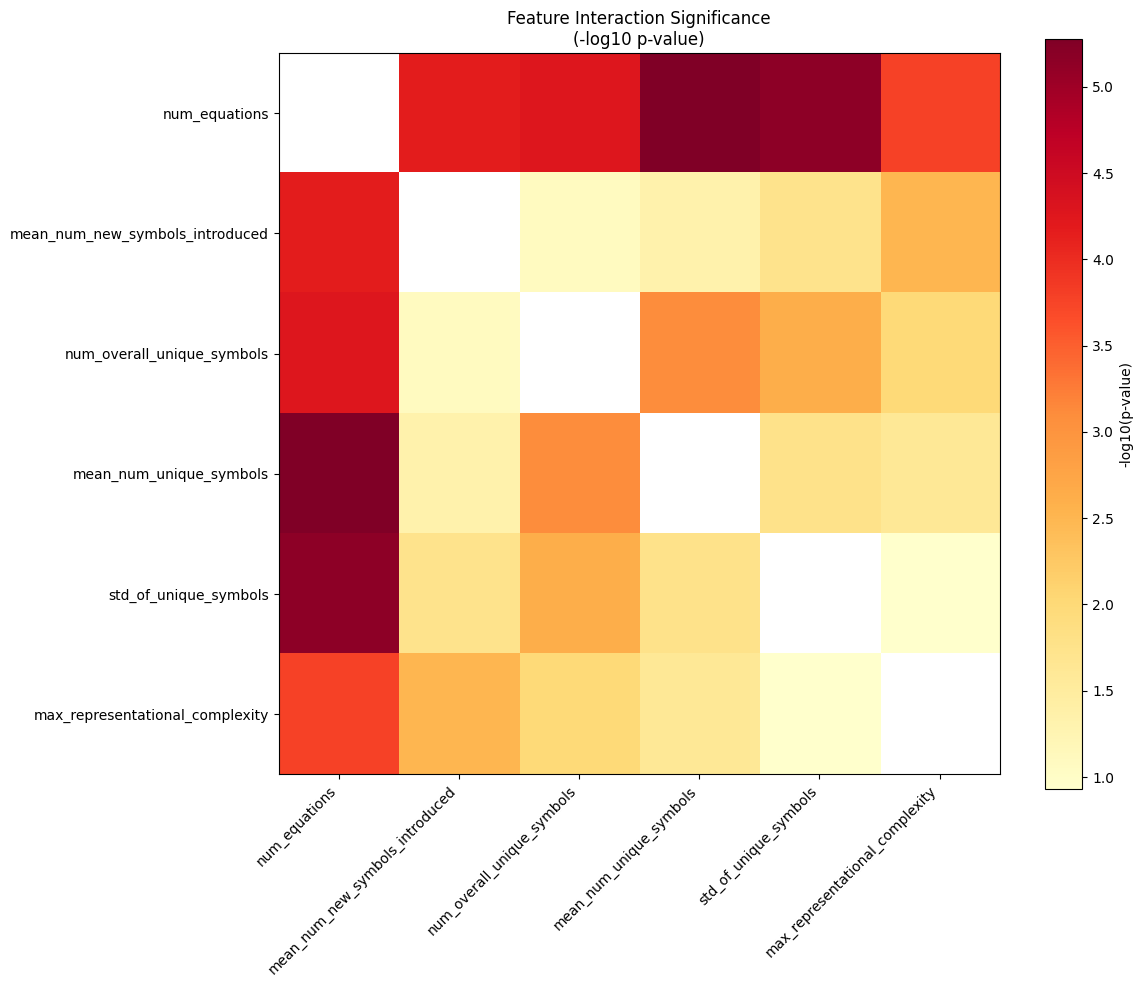

FEATURE INTERACTION ANALYSIS SUMMARY
Total number of papers: 957
Overall acceptance rate: 54.55%
Number of significant interactions: 13

SIGNIFICANT INTERACTIONS OVERVIEW:
+-------------------------------------------------------------------+---------------+-----------+
| Feature Pair                                                      |   F-statistic |   p-value |
+===================================================================+===============+===========+
| num_equations × mean_num_unique_symbols                           |        20.98  | 5.255e-06 |
+-------------------------------------------------------------------+---------------+-----------+
| num_equations × std_of_unique_symbols                             |        20.411 | 7.029e-06 |
+-------------------------------------------------------------------+---------------+-----------+
| num_equations × num_overall_unique_symbols                        |        16.487 | 5.301e-05 |
+-------------------------------------------

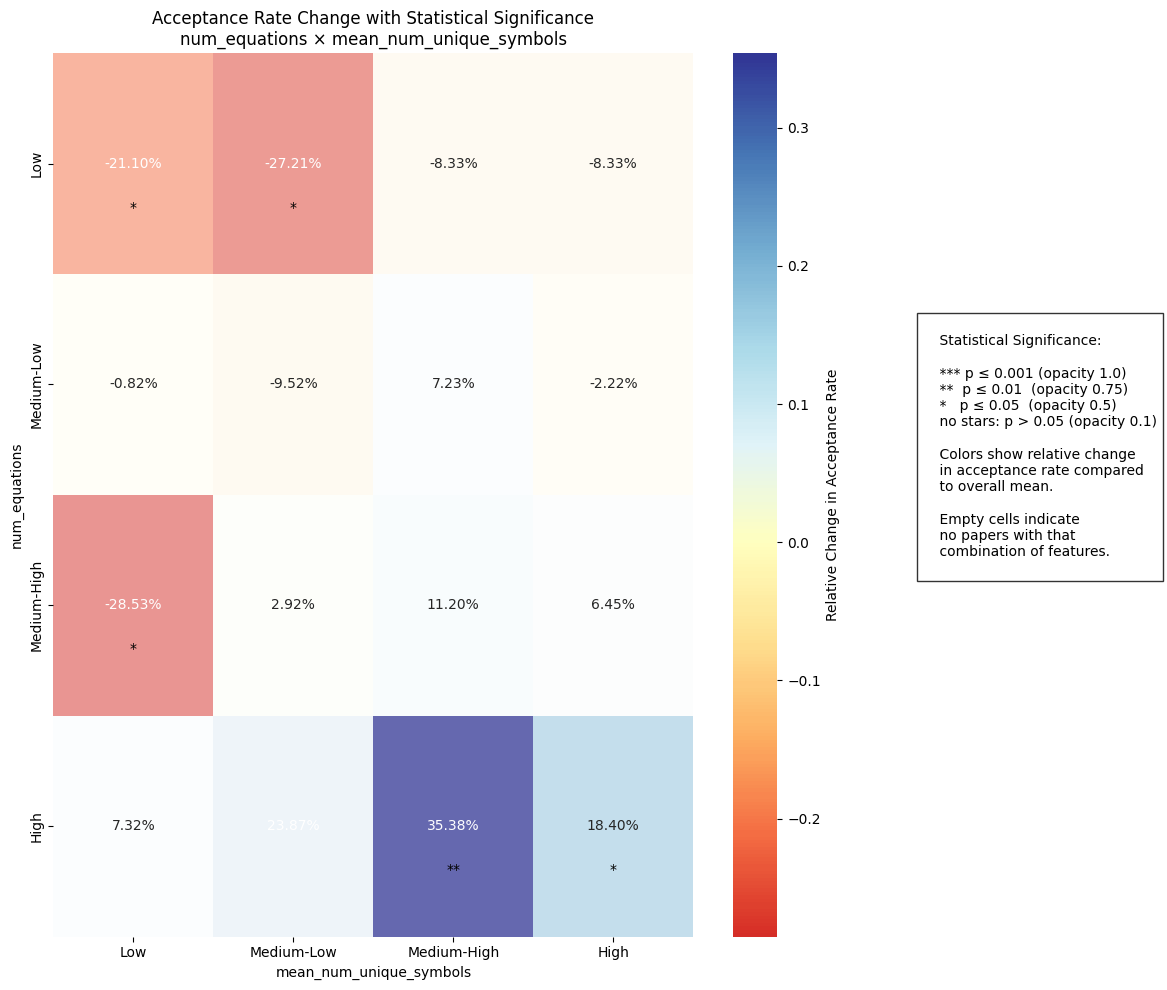

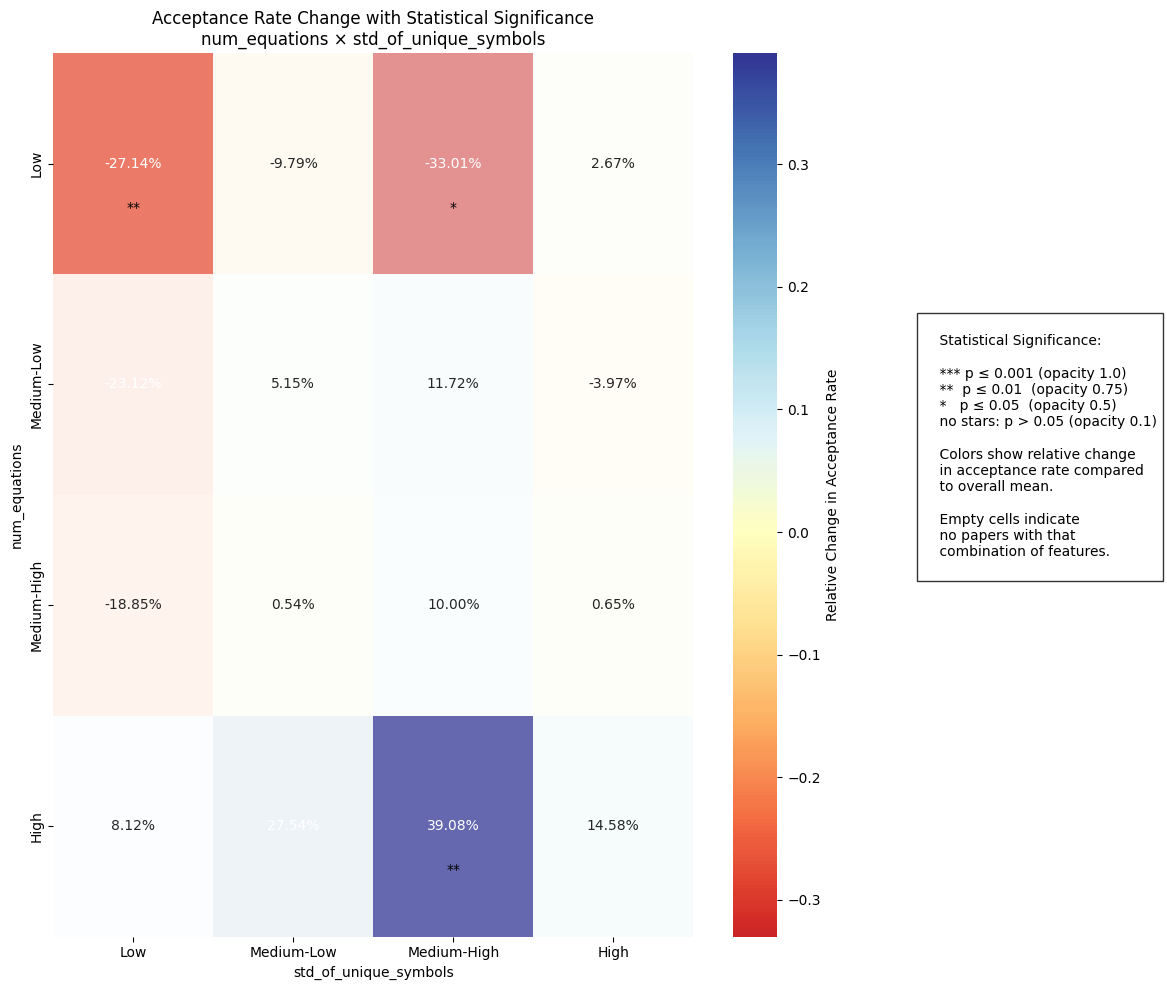

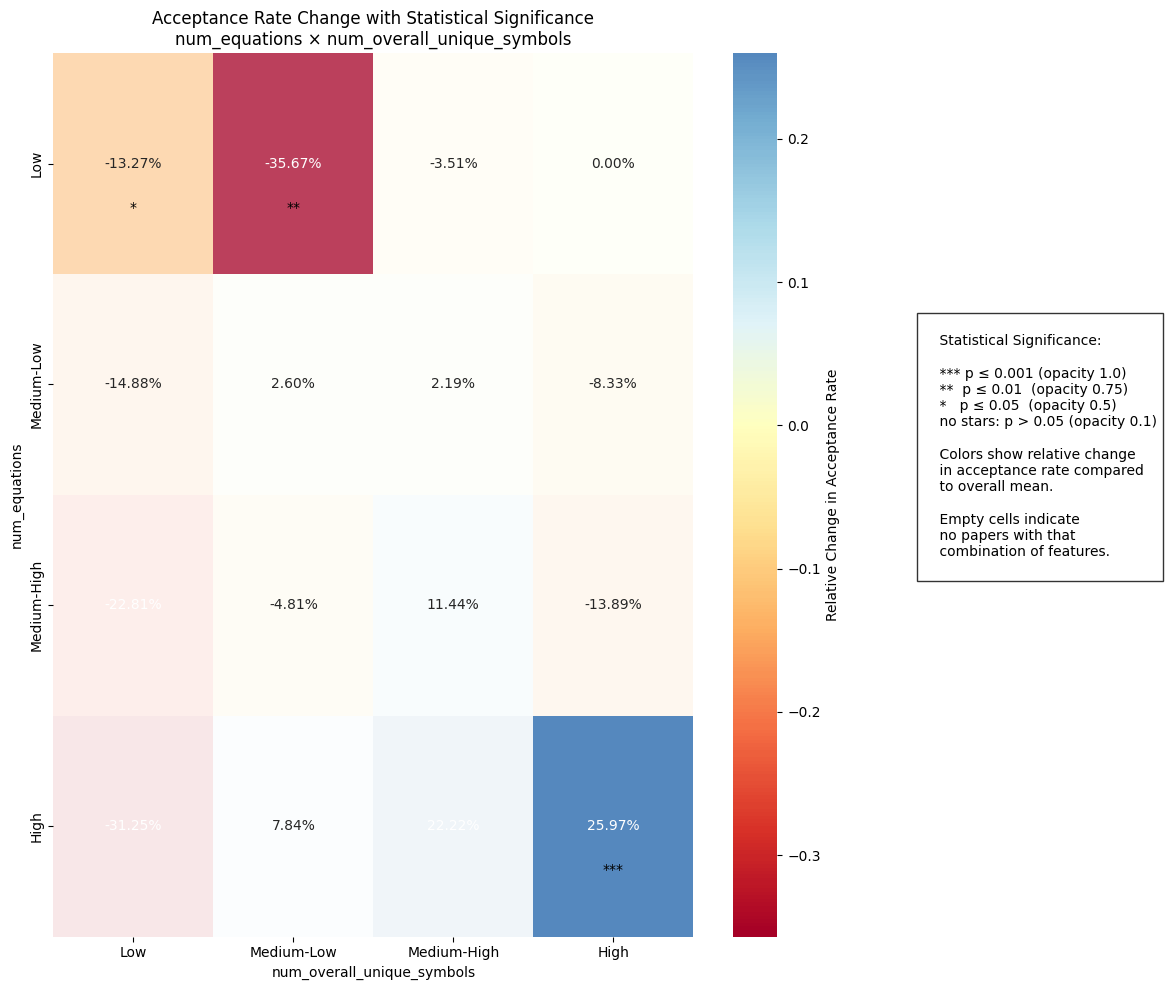

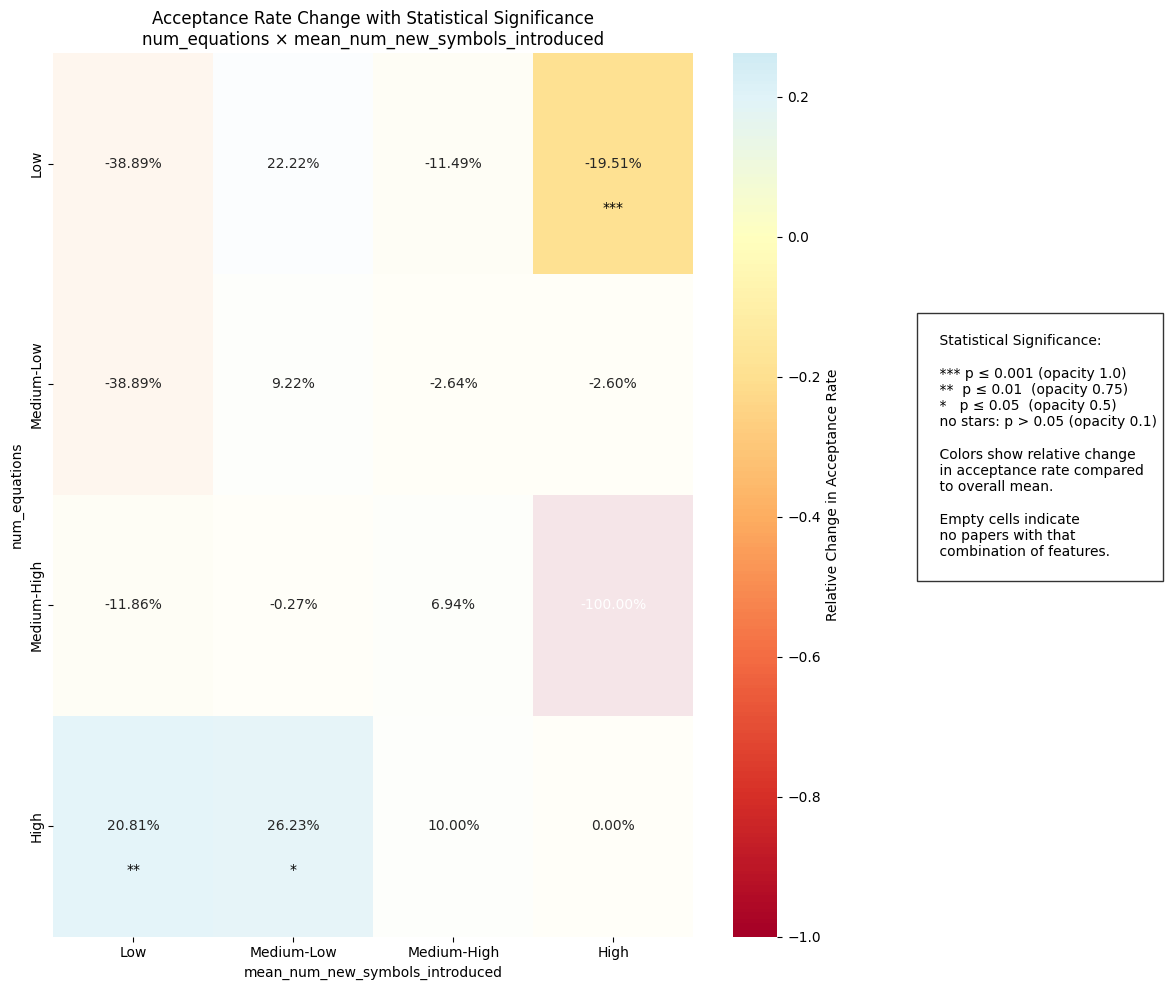

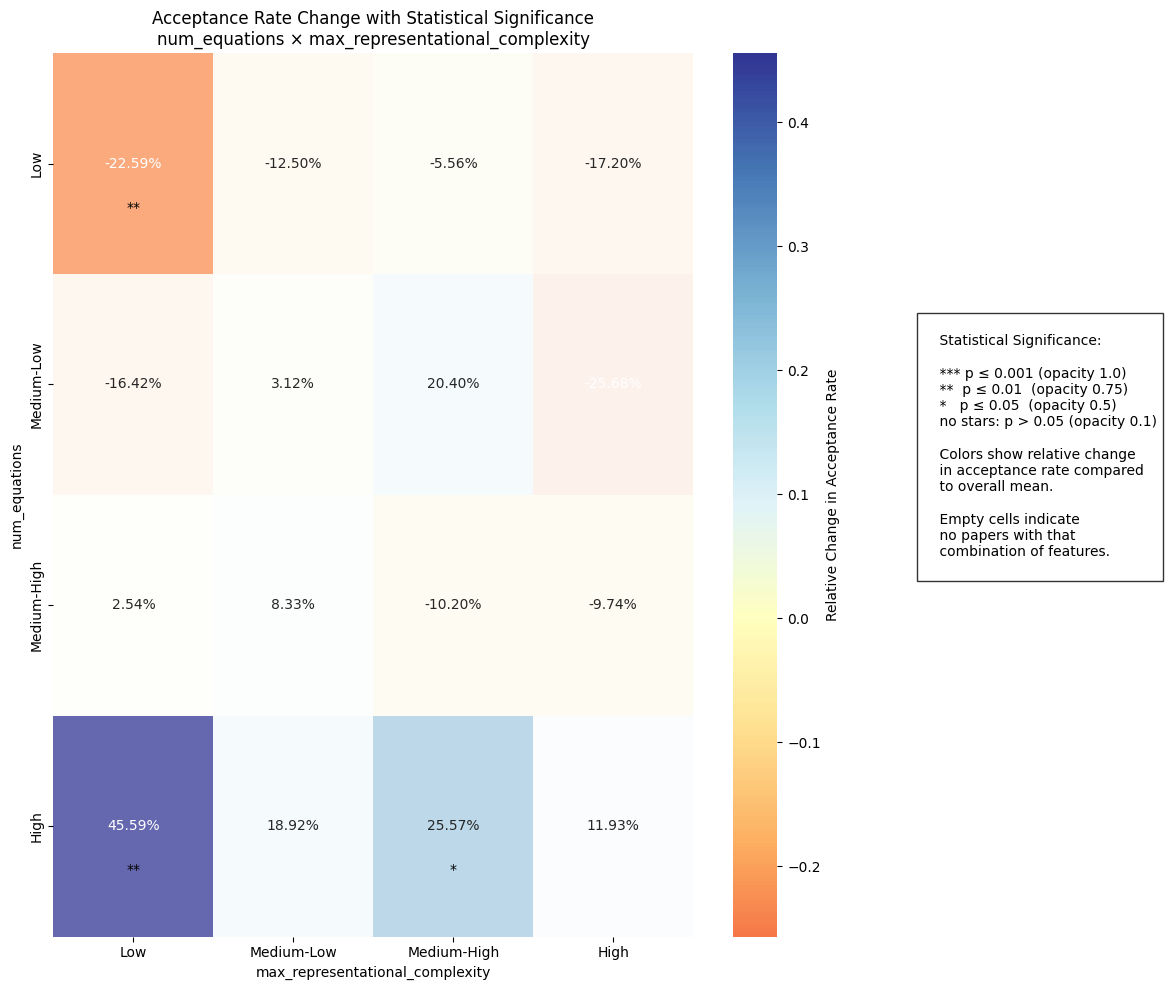

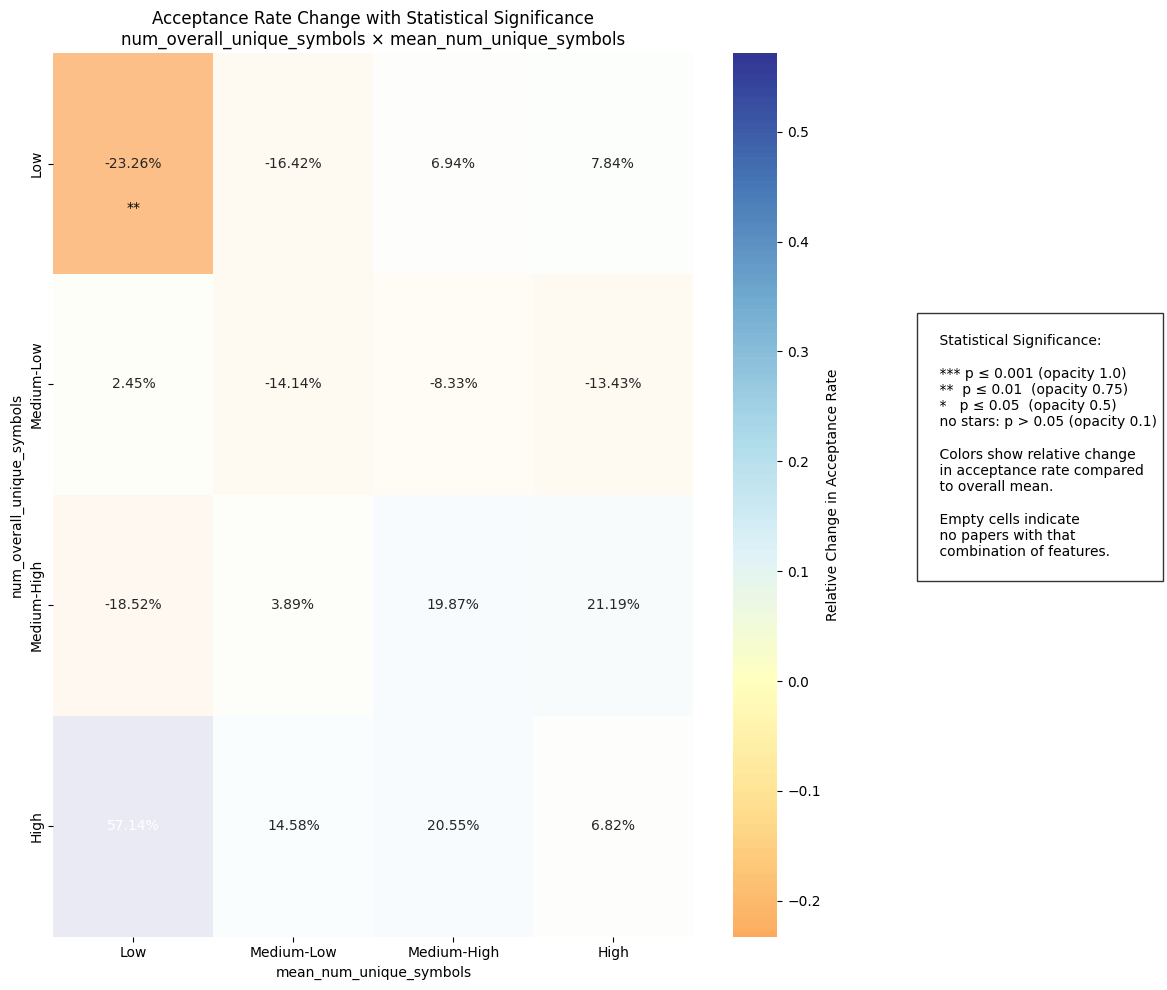

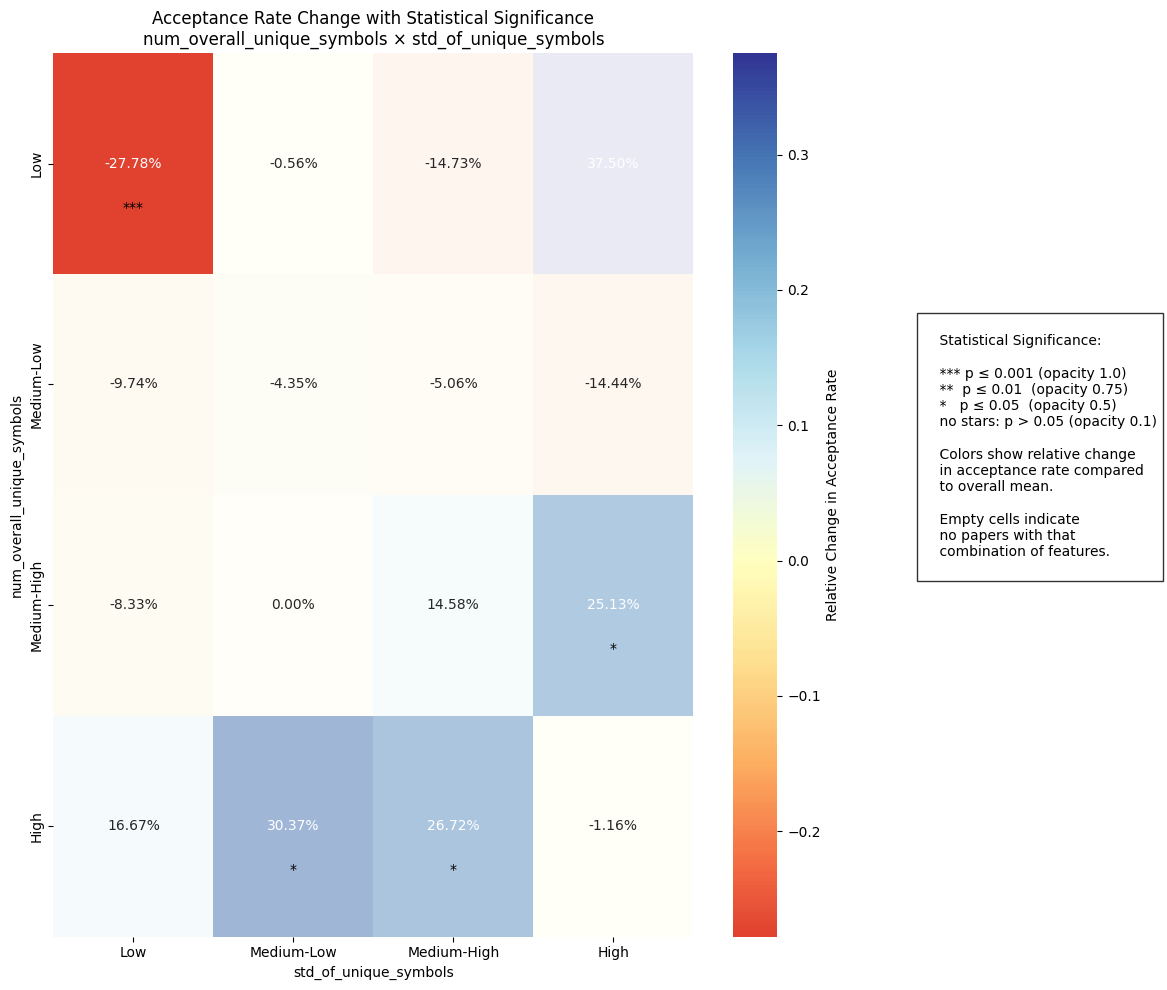

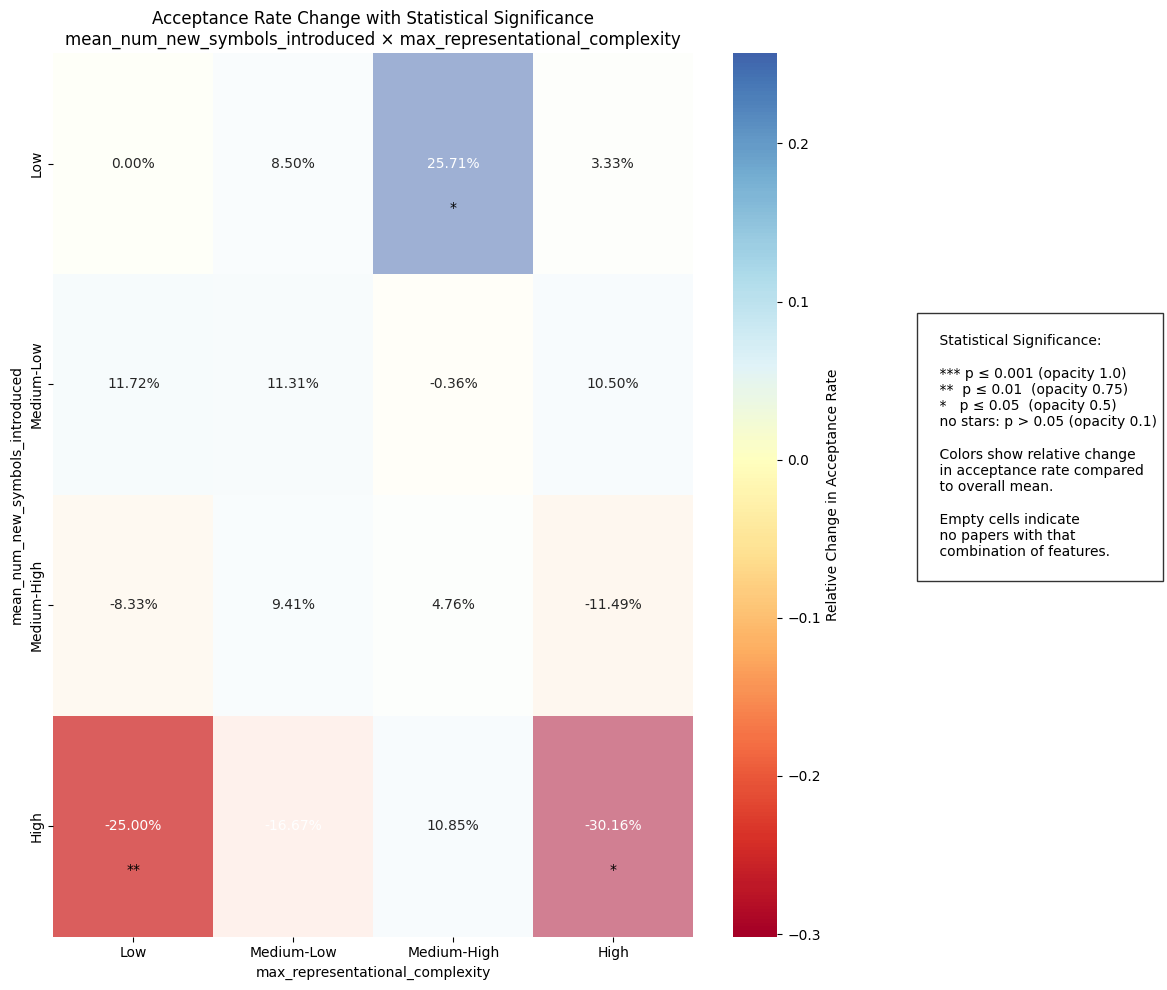

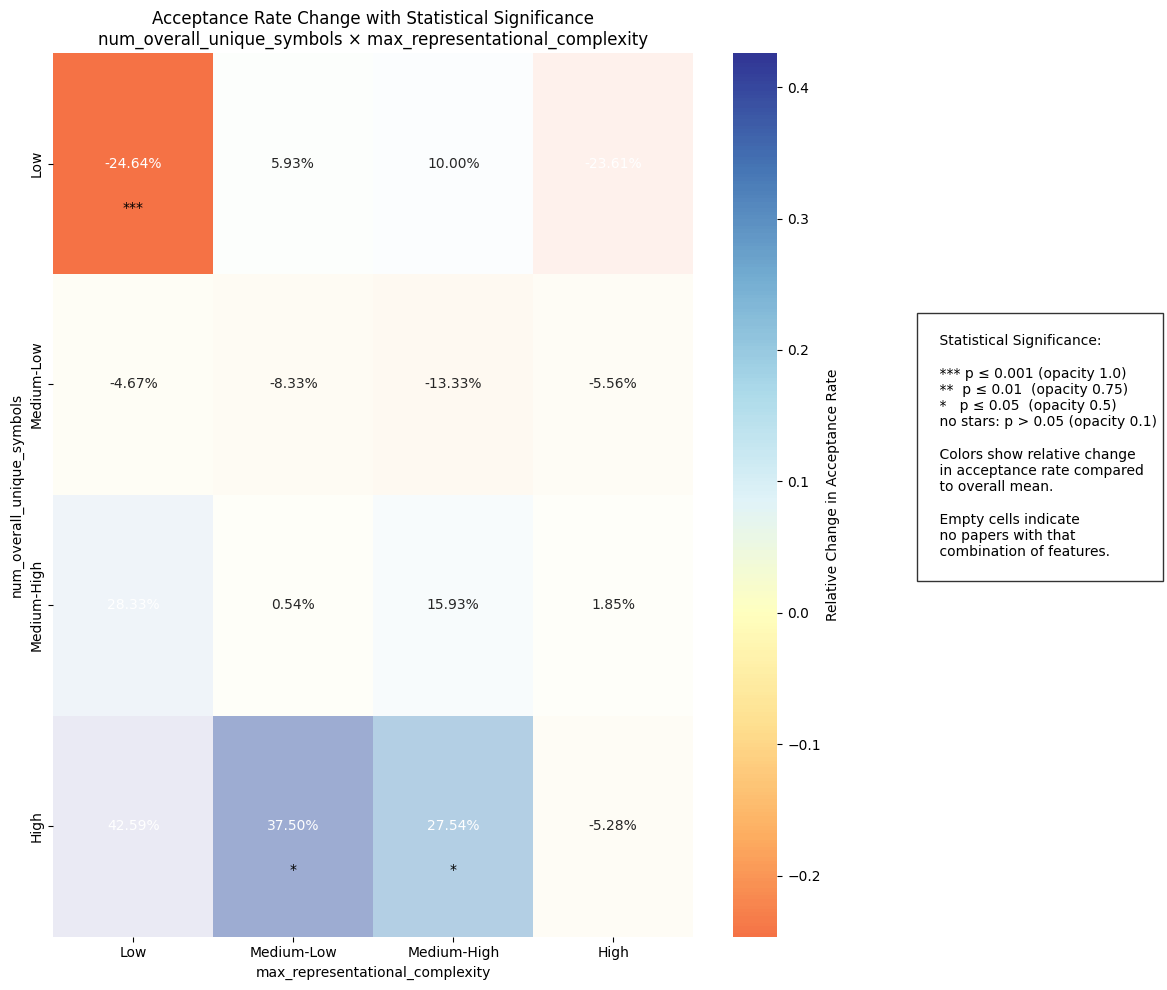

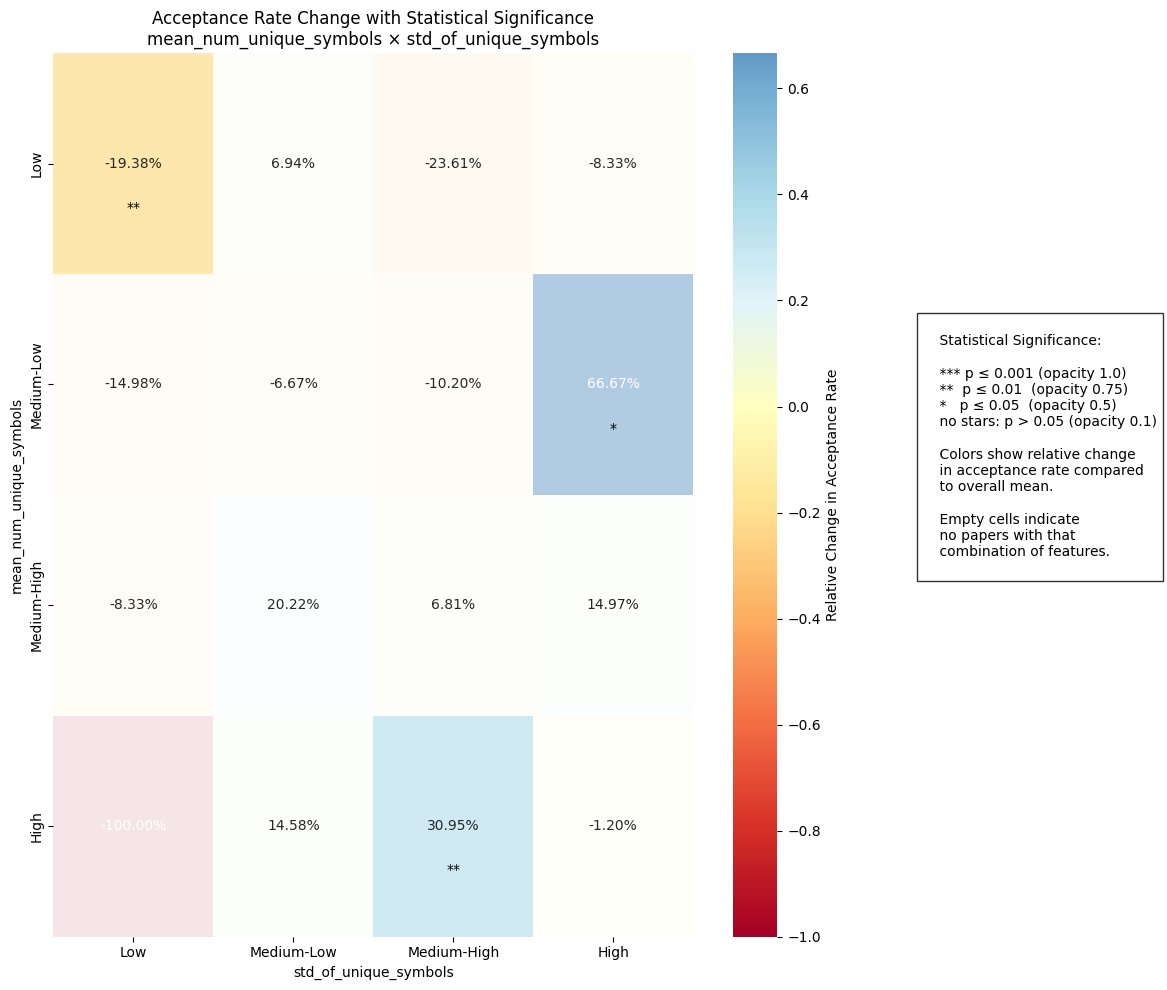

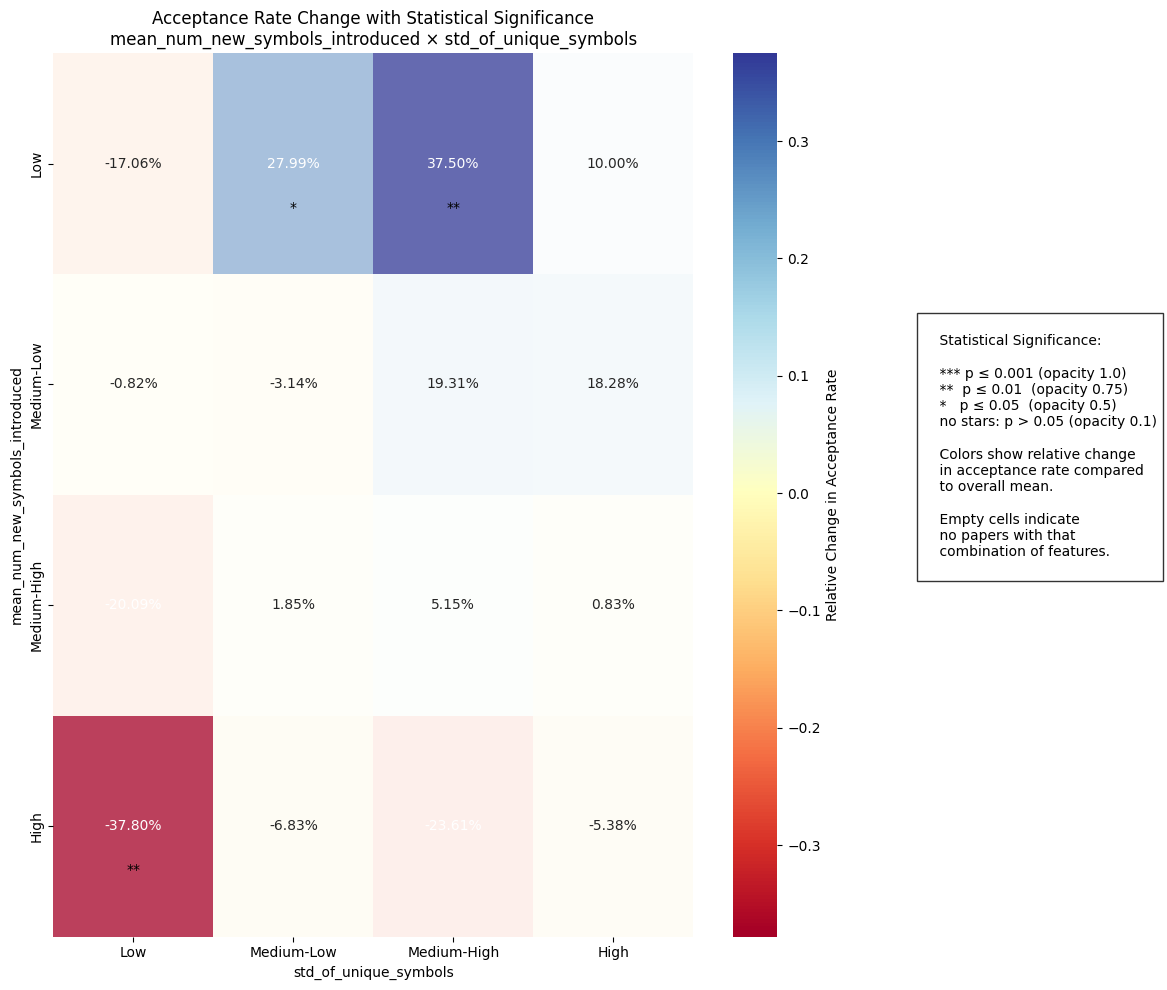

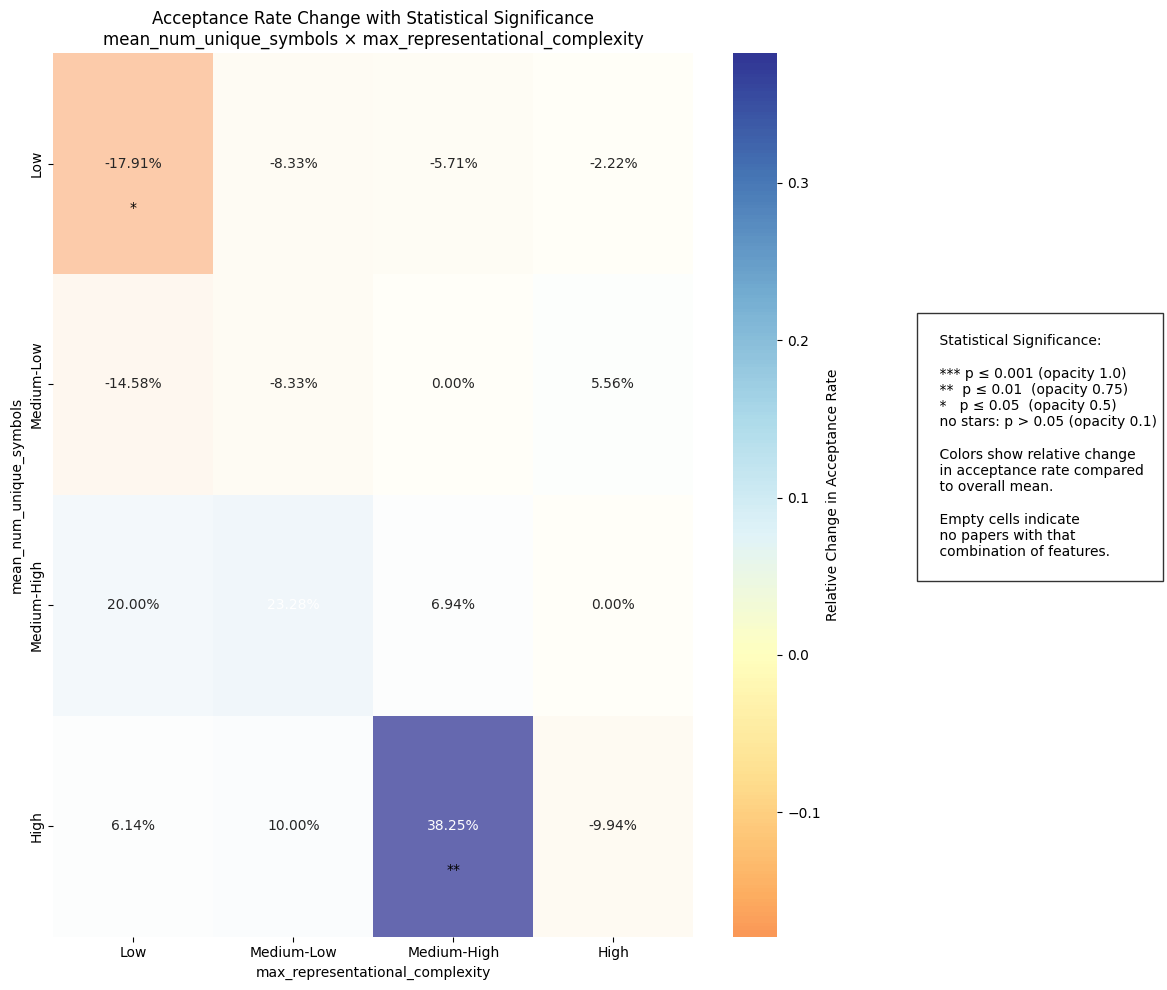

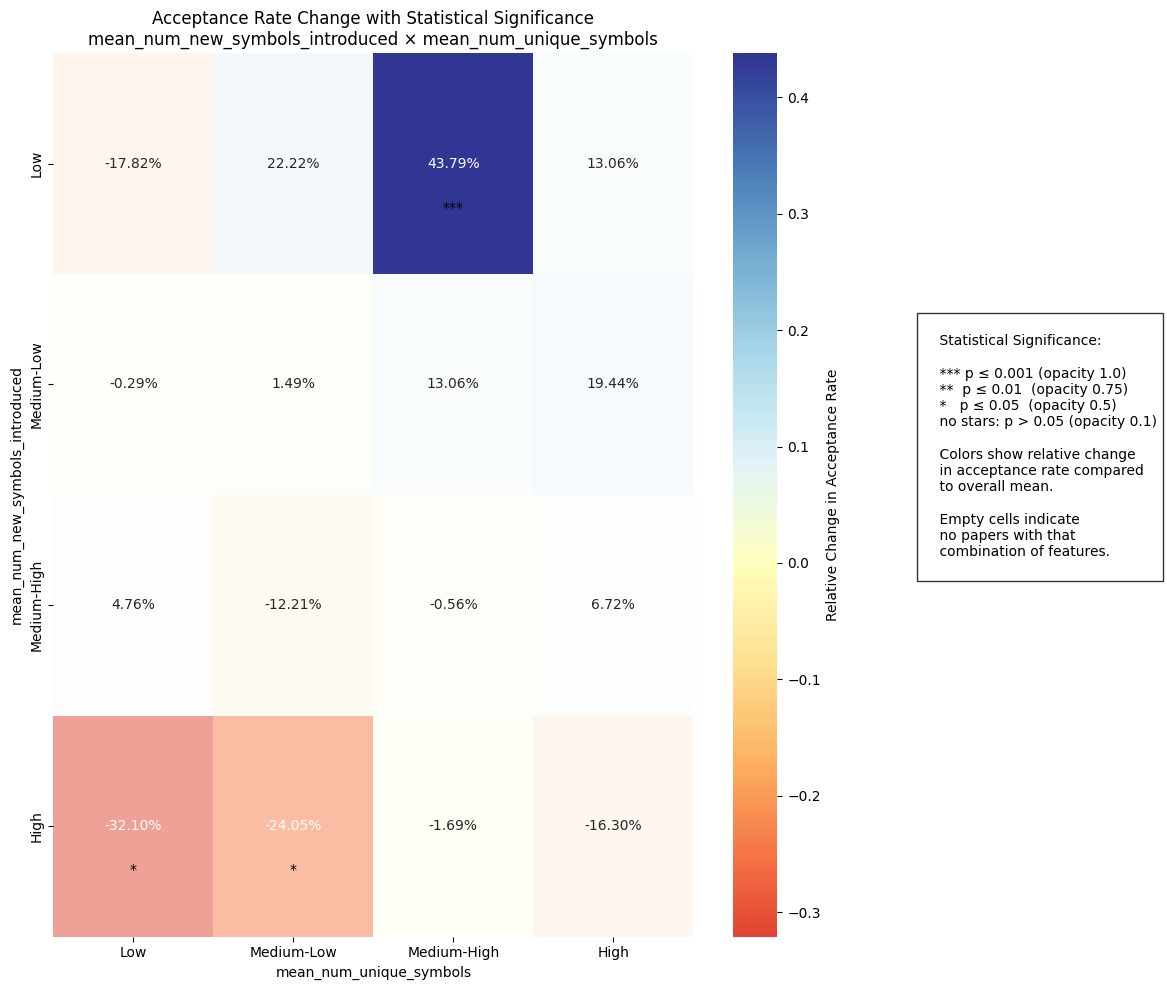

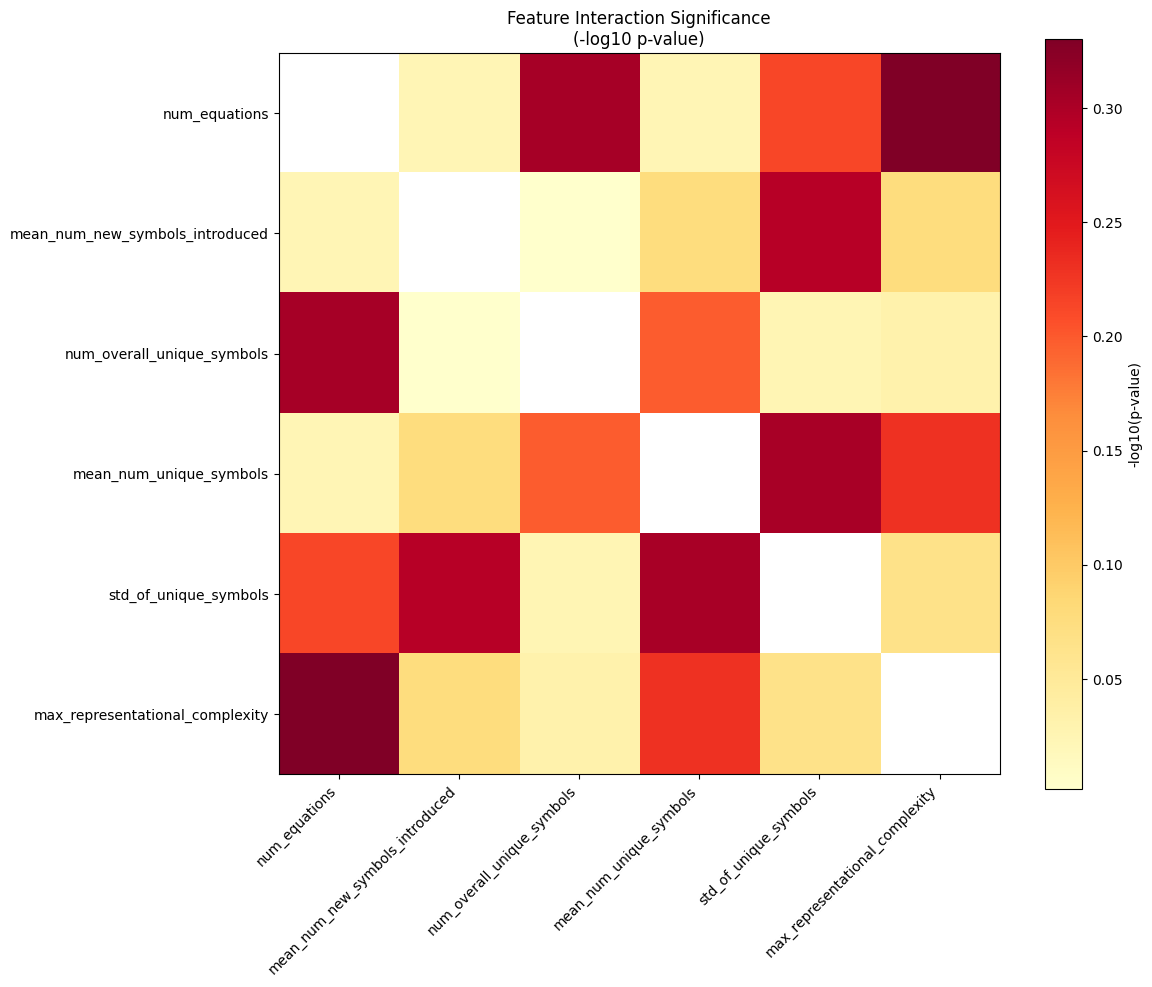

FEATURE INTERACTION ANALYSIS SUMMARY
Total number of papers: 2920
Overall acceptance rate: 94.90%
Number of significant interactions: 0

No significant interactions found.



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, fisher_exact, chi2_contingency

def perform_anova_analysis(data, labels, feature_names):
    """
    Perform two-way ANOVA analysis to identify significant feature interactions.
    Returns interactions sorted by significance for further detailed analysis.
    """
    interactions = []
    p_values = np.zeros((len(feature_names), len(feature_names)))
    f_stats = np.zeros((len(feature_names), len(feature_names)))
    
    # Analyze all possible feature pairs
    for i, feat1 in enumerate(feature_names):
        for j, feat2 in enumerate(feature_names):
            if i < j:  # Only compute upper triangle to avoid redundancy
                interaction = data[feat1] * data[feat2]
                accepted_inter = interaction[labels == 1]
                rejected_inter = interaction[labels == 0]
                
                f_stat, p_val = f_oneway(accepted_inter, rejected_inter)
                
                # Store results for visualization and sorting
                p_values[i, j] = p_val
                p_values[j, i] = p_val
                f_stats[i, j] = f_stat
                f_stats[j, i] = f_stat
                
                interactions.append({
                    'features': (feat1, feat2),
                    'f_statistic': f_stat,
                    'p_value': p_val
                })
    
    # Visualize overall interaction significance
    plt.figure(figsize=(12, 10))
    plt.imshow(-np.log10(p_values), cmap='YlOrRd')
    plt.colorbar(label='-log10(p-value)')
    plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
    plt.yticks(range(len(feature_names)), feature_names)
    plt.title('Feature Interaction Significance\n(-log10 p-value)')
    plt.tight_layout()
    plt.show()
    
    # Sort interactions by significance
    return sorted(interactions, key=lambda x: x['p_value'])

def analyze_feature_interaction(data, labels, feature1, feature2):
    """
    Analyze feature interactions with statistical significance testing for each combination.
    Shows all combinations with varying opacity and includes a detailed legend.
    
    Parameters:
    data: DataFrame containing the features
    labels: Binary acceptance labels
    feature1, feature2: Names of features to analyze
    """
    # Create quartile bins for both features
    q1 = pd.qcut(data[feature1], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    q2 = pd.qcut(data[feature2], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    
    # Initialize our measurement matrices
    acceptance_matrix = pd.DataFrame(
        np.zeros((4, 4)),
        index=['Low', 'Medium-Low', 'Medium-High', 'High'],
        columns=['Low', 'Medium-Low', 'Medium-High', 'High']
    )
    
    p_value_matrix = pd.DataFrame(
        np.ones((4, 4)),
        index=acceptance_matrix.index,
        columns=acceptance_matrix.columns
    )
    
    sample_size_matrix = pd.DataFrame(
        np.zeros((4, 4)),
        index=acceptance_matrix.index,
        columns=acceptance_matrix.columns
    )
    
    mean_acceptance = np.mean(labels)
    
    # Calculate statistics for each combination
    for i in acceptance_matrix.index:
        for j in acceptance_matrix.columns:
            mask = (q1 == i) & (q2 == j)
            cell_size = sum(mask)
            sample_size_matrix.loc[i, j] = cell_size
            
            if cell_size > 0:
                # Calculate relative acceptance rate
                acceptance_rate = np.mean(labels[mask])
                acceptance_matrix.loc[i, j] = acceptance_rate / mean_acceptance - 1
                
                # Perform statistical test
                accepted_in_cell = sum(labels[mask])
                rejected_in_cell = cell_size - accepted_in_cell
                accepted_others = sum(labels[~mask])
                rejected_others = sum(~mask) - accepted_others
                
                contingency_table = [[accepted_in_cell, rejected_in_cell],
                                   [accepted_others, rejected_others]]
                
                if cell_size < 30:
                    _, p_value = fisher_exact(contingency_table)
                else:
                    _, p_value, _, _ = chi2_contingency(contingency_table)
                
                p_value_matrix.loc[i, j] = p_value
    
    # Create figure with main heatmap and legend
    fig = plt.figure(figsize=(12, 10))
    
    # Create main axes for heatmap
    ax_heatmap = plt.subplot2grid((1, 20), (0, 0), colspan=15)
    
    # Calculate opacity based on statistical significance
    # Now using a more gradual scale that shows all results
    opacity_matrix = np.where(
        p_value_matrix <= 0.001, 1.0,
        np.where(p_value_matrix <= 0.01, 0.75,
        np.where(p_value_matrix <= 0.05, 0.5,
        0.1)))  # Very faint but visible for non-significant results
    
    # Create the heatmap
    sns.heatmap(acceptance_matrix,
                annot=True,
                fmt='.2%',
                cmap='RdYlBu',
                center=0,
                alpha=opacity_matrix,
                cbar_kws={'label': 'Relative Change in Acceptance Rate'},
                ax=ax_heatmap)
    
    # Add significance markers
    for i in range(4):
        for j in range(4):
            if sample_size_matrix.iloc[i, j] > 0:  # Only add markers where we have data
                significance = ''
                if p_value_matrix.iloc[i, j] <= 0.001:
                    significance = '***'
                elif p_value_matrix.iloc[i, j] <= 0.01:
                    significance = '**'
                elif p_value_matrix.iloc[i, j] <= 0.05:
                    significance = '*'
                ax_heatmap.text(j + 0.5, i + 0.7, significance,
                              ha='center', va='center',
                              color='black')
    
    ax_heatmap.set_title(f'Acceptance Rate Change with Statistical Significance\n{feature1} × {feature2}')
    ax_heatmap.set_xlabel(feature2)
    ax_heatmap.set_ylabel(feature1)
    
    # Create legend axes
    ax_legend = plt.subplot2grid((1, 20), (0, 16), colspan=4)
    ax_legend.axis('off')
    
    # Add legend text
    legend_text = """
    Statistical Significance:
    
    *** p ≤ 0.001 (opacity 1.0)
    **  p ≤ 0.01  (opacity 0.75)
    *   p ≤ 0.05  (opacity 0.5)
    no stars: p > 0.05 (opacity 0.1)
    
    Colors show relative change
    in acceptance rate compared
    to overall mean.
    
    Empty cells indicate
    no papers with that
    combination of features.
    """
    ax_legend.text(0, 0.7, legend_text,
                  fontsize=10,
                  verticalalignment='top',
                  bbox=dict(facecolor='white',
                           edgecolor='black',
                           alpha=0.8))
    
    plt.tight_layout()
    return acceptance_matrix, p_value_matrix, sample_size_matrix

def analyze_significant_interactions(data, labels, feature_names, p_value_threshold=0.05):
    """
    Perform comprehensive interaction analysis by combining ANOVA and detailed visualization
    for all significant feature pairs.
    """
    # First, identify significant interactions using ANOVA
    print("Performing initial ANOVA analysis...")
    interactions = perform_anova_analysis(data, labels, feature_names)
    
    # Filter significant interactions
    significant_interactions = [x for x in interactions if x['p_value'] < p_value_threshold]
    
    print(f"\nFound {len(significant_interactions)} significant interactions (p < {p_value_threshold})")
    
    # Analyze each significant interaction in detail
    for interaction in significant_interactions:
        feat1, feat2 = interaction['features']
        print(f"\nAnalyzing interaction: {feat1} × {feat2}")
        print(f"F-statistic: {interaction['f_statistic']:.3f}")
        print(f"p-value: {interaction['p_value']:.3e}")
        
        # Perform detailed analysis of the interaction
        acc_matrix, p_value_matrix, sample_size_matrix = analyze_feature_interaction(
            data, labels, feat1, feat2
        )

def analyze_interactions(data, labels, feature_names, p_value_threshold=0.05):
    """
    Generate a comprehensive tabular summary of feature interactions and their statistical significance.
    Returns a formatted string containing all relevant information in an easily parseable format.
    """
    from tabulate import tabulate
    
    # First, perform ANOVA analysis
    interactions = perform_anova_analysis(data, labels, feature_names)
    significant_interactions = [x for x in interactions if x['p_value'] < p_value_threshold]
    
    # Initialize our summary string
    summary = f"FEATURE INTERACTION ANALYSIS SUMMARY\n"
    summary += f"Total number of papers: {len(labels)}\n"
    summary += f"Overall acceptance rate: {np.mean(labels)*100:.2f}%\n"
    summary += f"Number of significant interactions: {len(significant_interactions)}\n\n"
    
    if len(significant_interactions) == 0:
        summary += "No significant interactions found.\n"
        return summary
    
    # Create a summary table of significant interactions
    interaction_table = []
    for interaction in significant_interactions:
        feat1, feat2 = interaction['features']
        interaction_table.append([
            f"{feat1} × {feat2}",
            f"{interaction['f_statistic']:.3f}",
            f"{interaction['p_value']:.3e}"
        ])
    
    summary += "SIGNIFICANT INTERACTIONS OVERVIEW:\n"
    summary += tabulate(interaction_table,
                       headers=['Feature Pair', 'F-statistic', 'p-value'],
                       tablefmt='grid') + "\n\n"
    
    # For each significant interaction, perform detailed analysis
    for interaction in significant_interactions:
        feat1, feat2 = interaction['features']
        acc_matrix, p_value_matrix, sample_size_matrix = analyze_feature_interaction(
            data, labels, feat1, feat2
        )
        
        summary += f"DETAILED ANALYSIS: {feat1} × {feat2}\n"
        summary += f"F-statistic: {interaction['f_statistic']:.3f}, p-value: {interaction['p_value']:.3e}\n\n"
        
        # Create a combined matrix for display
        combined_matrix = []
        for i in acc_matrix.index:
            for j in acc_matrix.columns:
                # Format significance stars
                significance = ''
                if p_value_matrix.loc[i, j] <= 0.001:
                    significance = '***'
                elif p_value_matrix.loc[i, j] <= 0.01:
                    significance = '**'
                elif p_value_matrix.loc[i, j] <= 0.05:
                    significance = '*'
                
                # Only include combinations where we have data
                if sample_size_matrix.loc[i, j] > 0:
                    combined_matrix.append([
                        i,  # First feature level
                        j,  # Second feature level
                        f"{acc_matrix.loc[i, j]*100:+.2f}%",  # Relative acceptance rate change
                        int(sample_size_matrix.loc[i, j]),  # Sample size
                        f"{p_value_matrix.loc[i, j]:.3e}",  # p-value
                        significance  # Significance stars
                    ])
        
        summary += "Detailed Statistics by Feature Combination:\n"
        summary += tabulate(combined_matrix,
                          headers=[f'{feat1} Level', 
                                 f'{feat2} Level',
                                 'Rel. Acceptance Δ',
                                 'Sample Size',
                                 'p-value',
                                 'Significance'],
                          tablefmt='grid') + "\n\n"
        
        summary += "Significance levels: *** p≤0.001, ** p≤0.01, * p≤0.05\n"
        summary += "Relative Acceptance Δ shows percentage change from mean acceptance rate\n\n"
        summary += "-" * 80 + "\n\n"
    
    return summary

# Run the analysis for both conferences
for conf_name, features, labels in [('ICLR', iclr_features, iclr_labels),
                                  ('NeurIPS', neurips_features, neurips_labels)]:
    print(f"\n{'='*80}")
    print(f"{conf_name} INTERACTION ANALYSIS")
    print(f"{'='*80}\n")
    
    summary = analyze_interactions(features, labels, FEATURE_NAMES)
    print(summary)

## Machine Learning Analysis

Performing comprehensive analysis...

==================== ICLR Analysis ====================

Performing PCA analysis...

PCA Analysis Results:

Explained Variance Ratio:
PC1: 0.5303 (53.03%)
PC2: 0.2731 (27.31%)

Component Loadings:
Feature                PC1        PC2
-------------------------------------
num_equations        0.311     -0.545
mean_num_new_symbols_introduced     -0.161      0.642
num_overall_unique_symbols      0.488     -0.195
mean_num_unique_symbols      0.452      0.322
std_of_unique_symbols      0.468      0.371
max_representational_complexity      0.465      0.106
Explained variance ratio: PC1=53.03%, PC2=27.31%


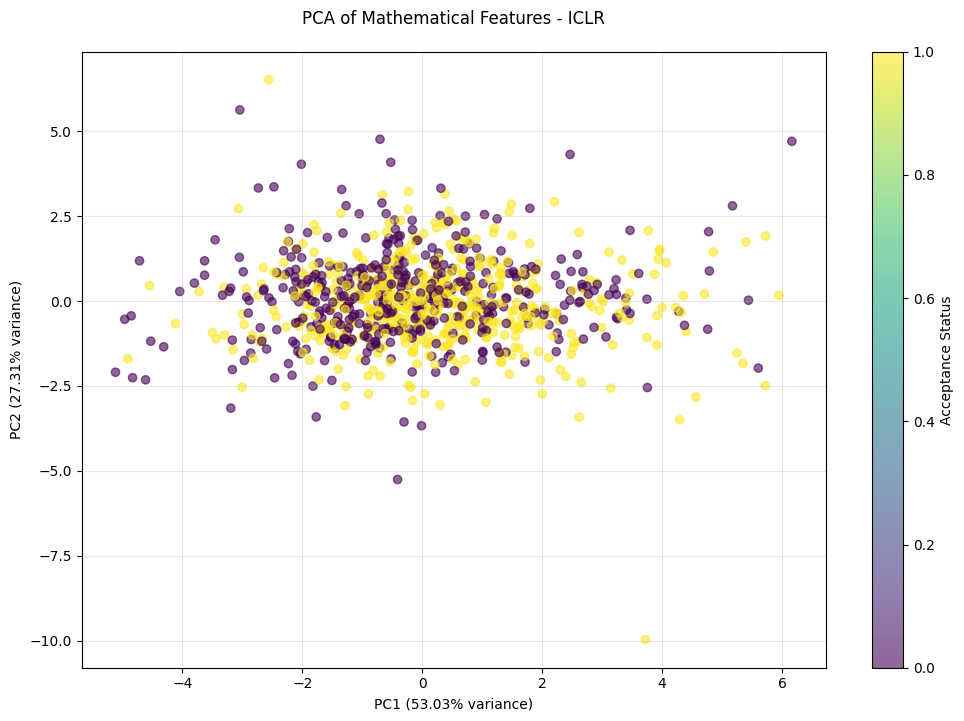


Analyzing feature interactions...

Feature Interaction Statistics:

num_equations vs mean_num_new_symbols_introduced:
Correlation coefficient: -0.555
Accepted papers (mean ± std):
- num_equations: 547.546 ± 509.561
- mean_num_new_symbols_introduced: 0.197 ± 0.128
Rejected papers (mean ± std):
- num_equations: 424.936 ± 369.412
- mean_num_new_symbols_introduced: 0.233 ± 0.158

num_equations vs num_overall_unique_symbols:
Correlation coefficient: 0.643
Accepted papers (mean ± std):
- num_equations: 547.546 ± 509.561
- num_overall_unique_symbols: 72.239 ± 30.866
Rejected papers (mean ± std):
- num_equations: 424.936 ± 369.412
- num_overall_unique_symbols: 64.343 ± 29.727

num_equations vs mean_num_unique_symbols:
Correlation coefficient: 0.165
Accepted papers (mean ± std):
- num_equations: 547.546 ± 509.561
- mean_num_unique_symbols: 3.287 ± 1.412
Rejected papers (mean ± std):
- num_equations: 424.936 ± 369.412
- mean_num_unique_symbols: 2.998 ± 1.407

num_equations vs std_of_unique_symb

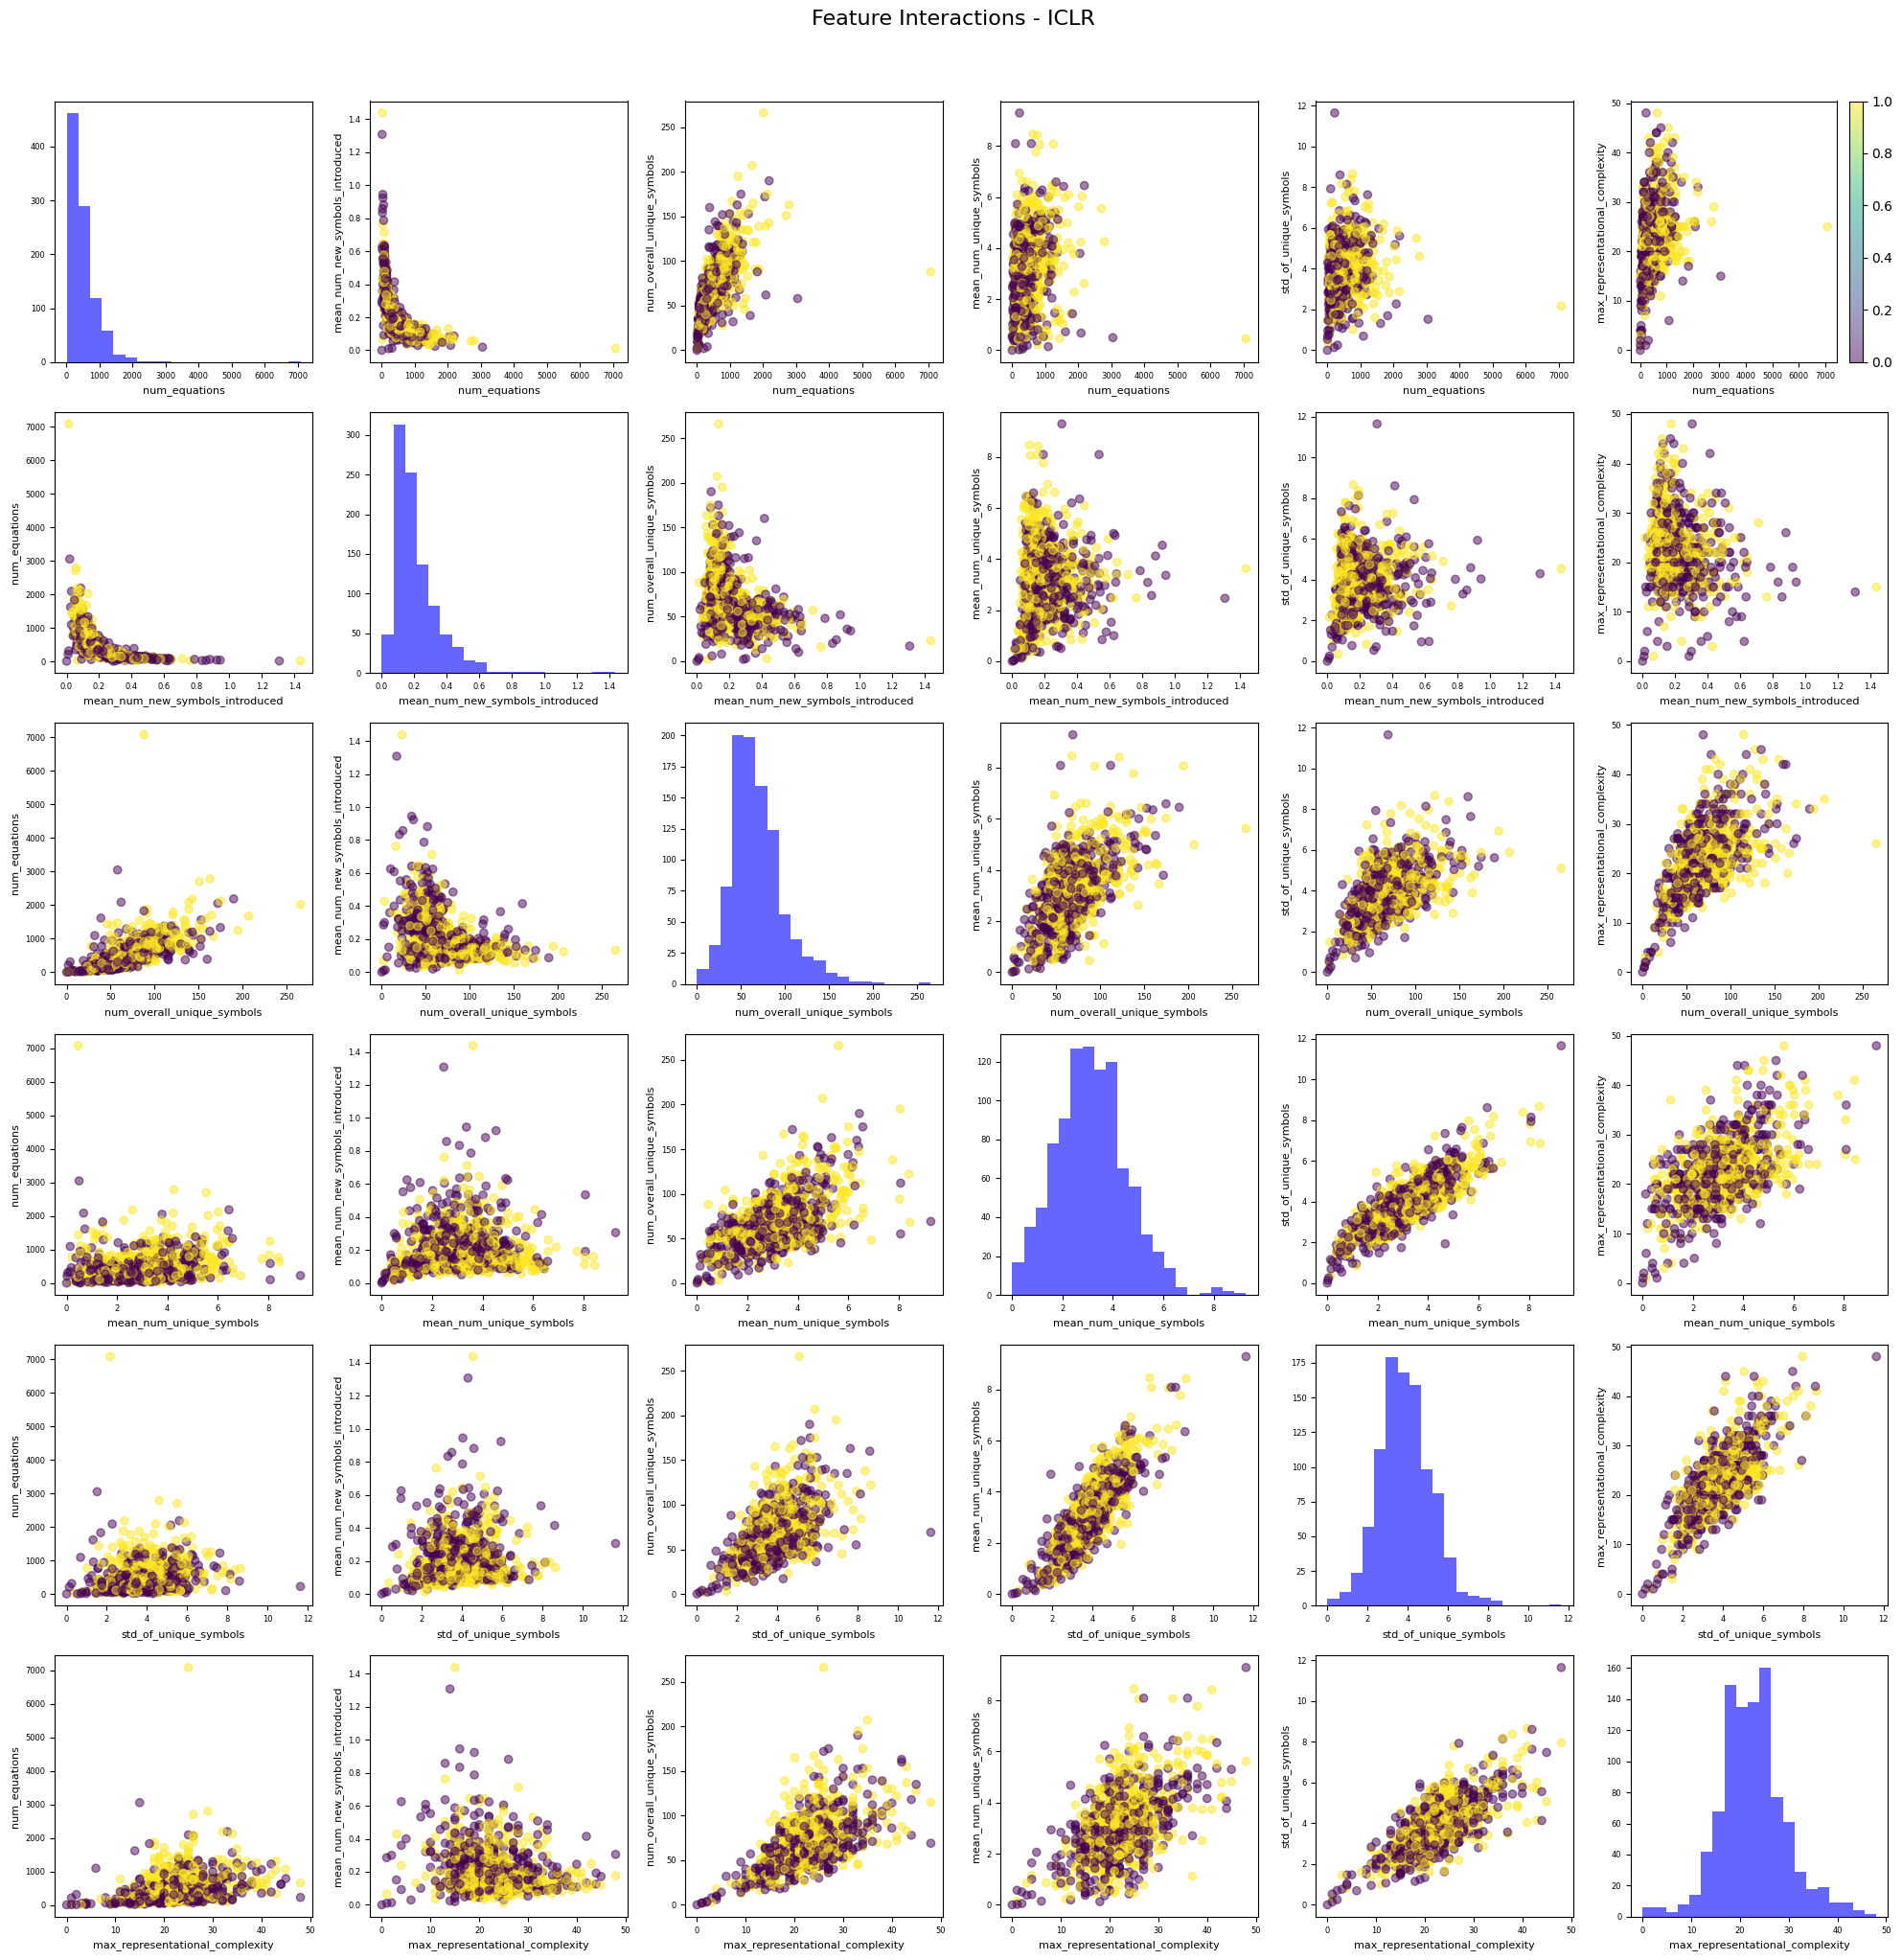


Training and evaluating models...

Detailed Model Performance Results for ICLR Model Performance

Accuracy:
--------------------------------------------------

Regular Models:
Model                      Mean        Std
------------------------------------------
SVM RBF                   0.564      0.025
LogisticRegression        0.562      0.021
Gradient Boosting         0.559      0.023
Random Forest             0.558      0.026
SVM Linear                0.553      0.034
XGBoost                   0.547      0.020
Decision Tree             0.541      0.022
Always Accept             0.537      0.028
Neural Network            0.520      0.018
Random Guess              0.505      0.015
Always Reject             0.463      0.028

SMOTEEN Models:
Model                      Mean        Std
------------------------------------------
Smoteen Gradient Boosting      0.560      0.020
Smoteen LogisticRegression      0.553      0.006
Smoteen SVM RBF           0.549      0.026
Smoteen XGBoost      

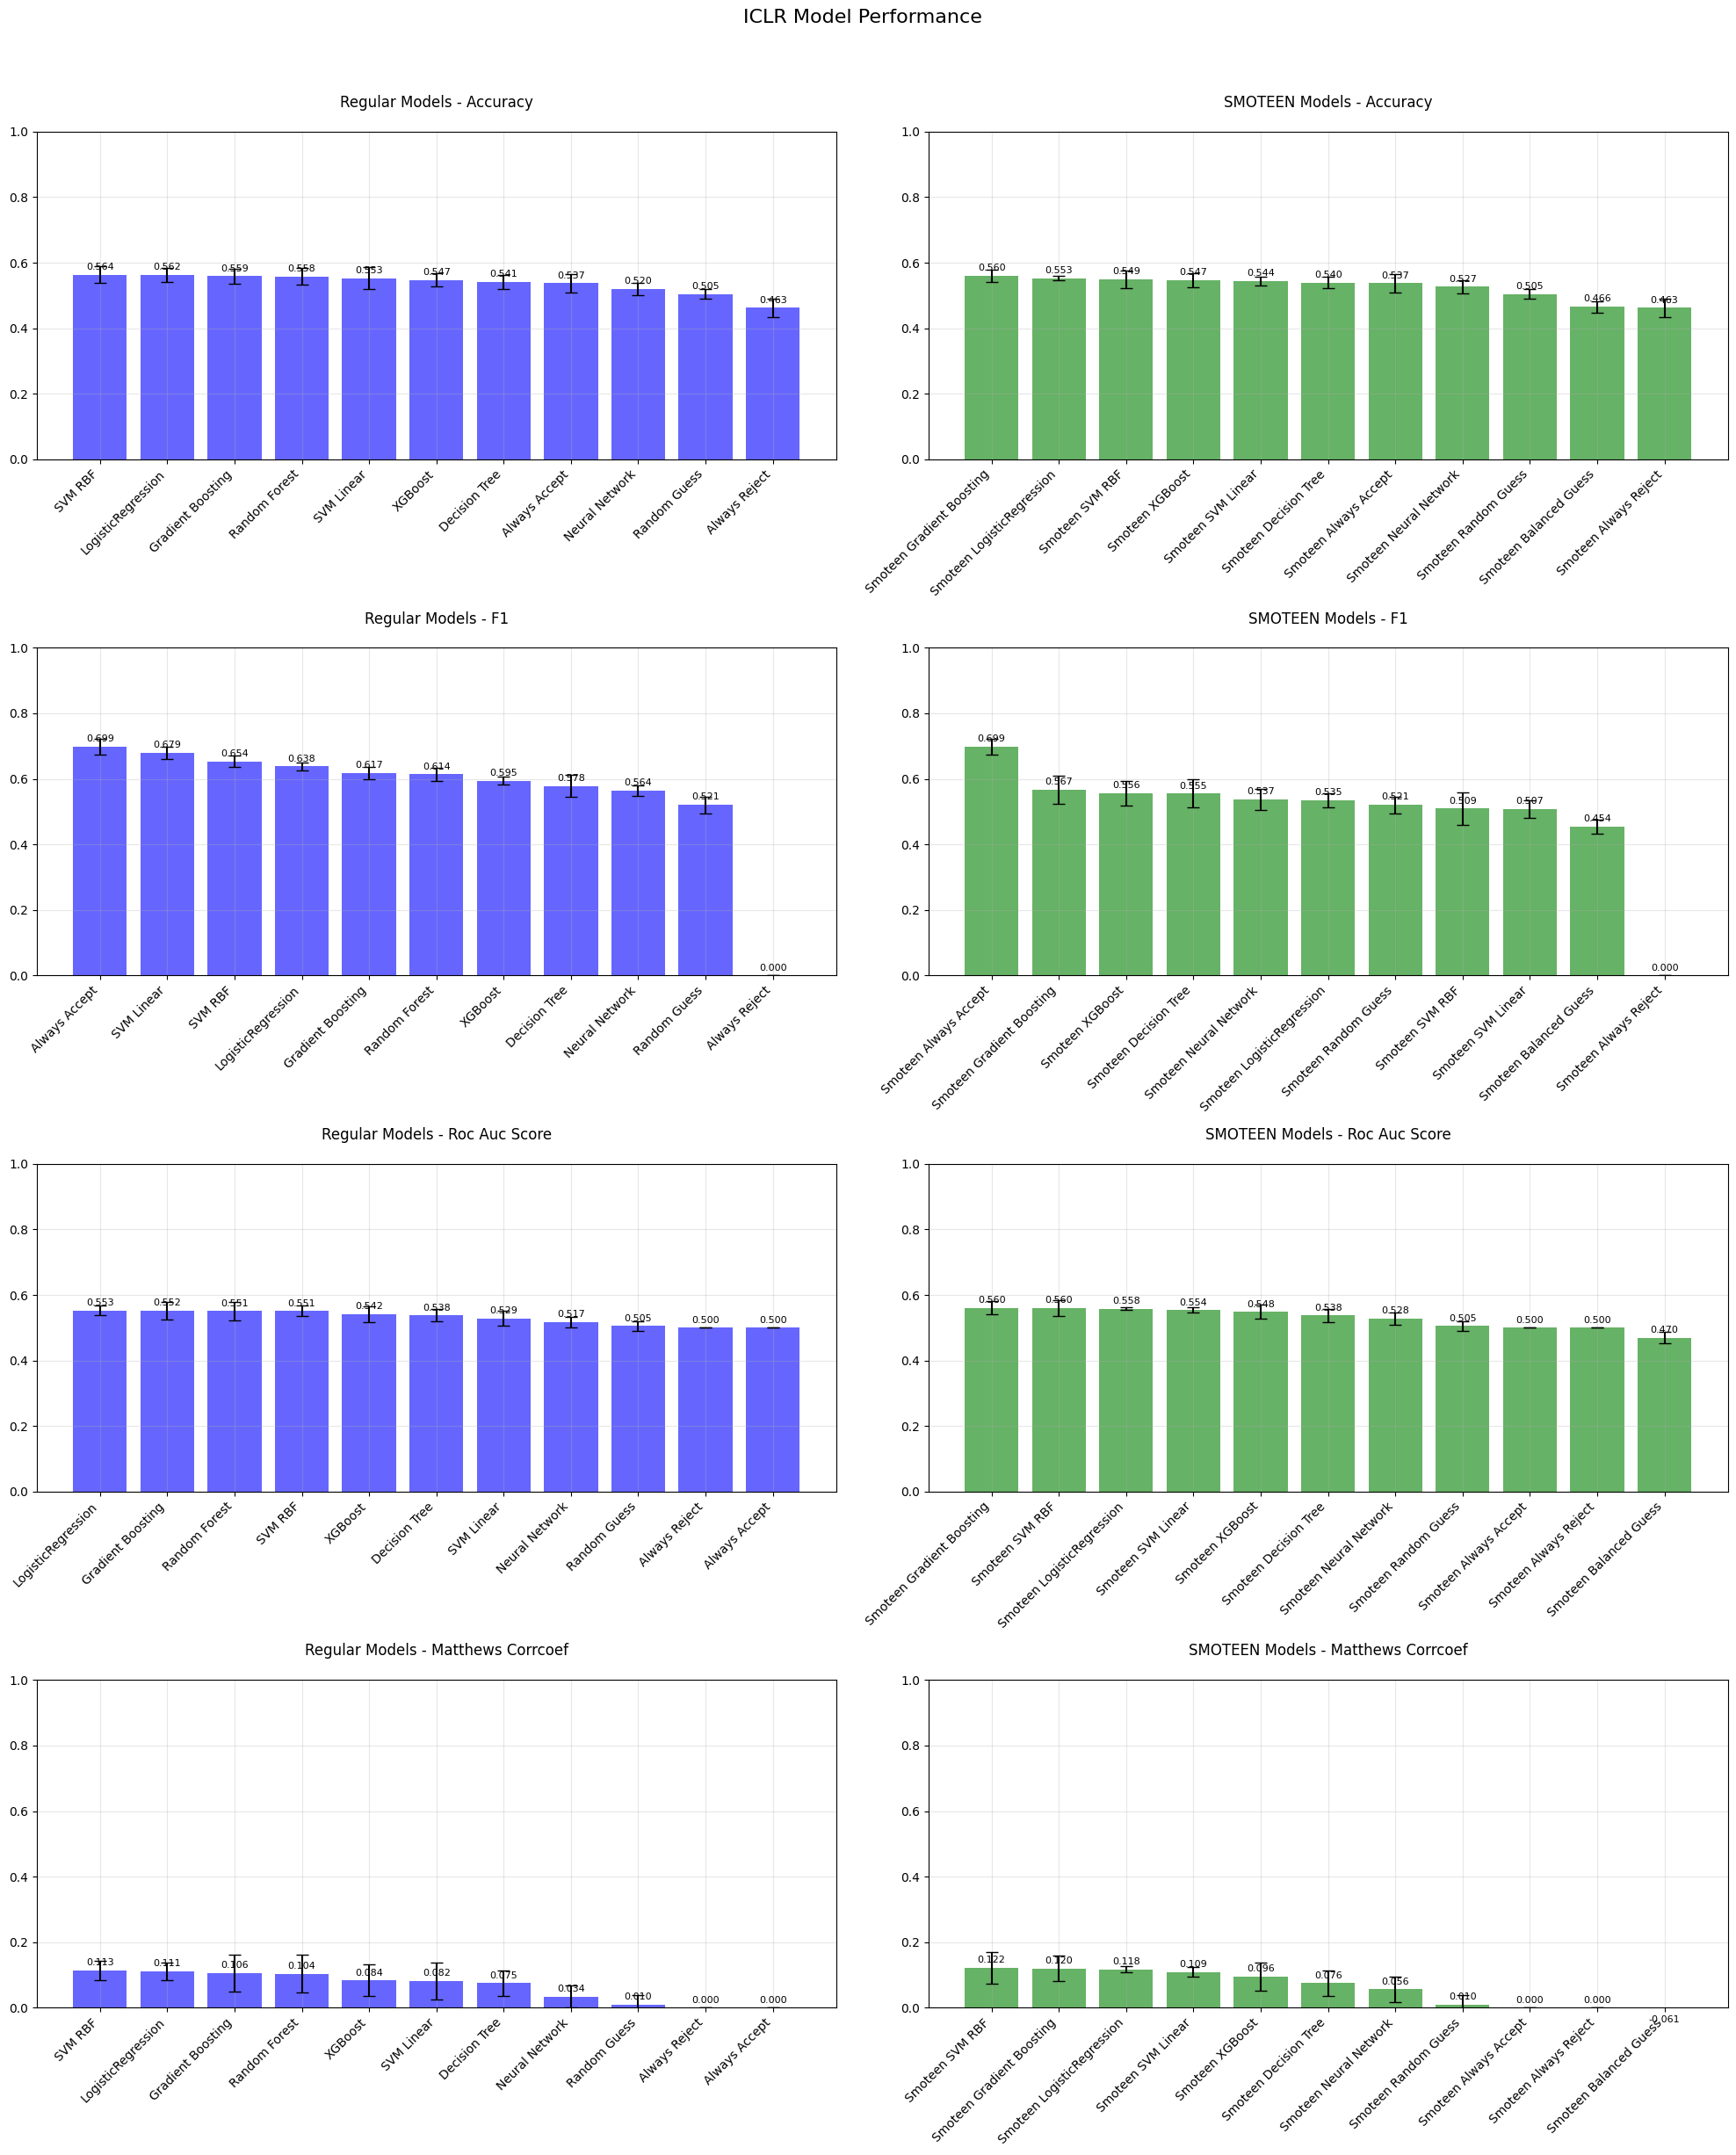


Best performing model: Smoteen Gradient Boosting

Analyzing feature importance...

Feature Importance:
                        Feature  Importance      Std
mean_num_new_symbols_introduced    0.023611 0.024689
        mean_num_unique_symbols    0.020486 0.009375
     num_overall_unique_symbols    0.010764 0.010236
          std_of_unique_symbols    0.008333 0.006804
max_representational_complexity    0.003472 0.008217
                  num_equations   -0.004514 0.007615



==================== NeurIPS Analysis ====================

Performing PCA analysis...

PCA Analysis Results:

Explained Variance Ratio:
PC1: 0.5143 (51.43%)
PC2: 0.2465 (24.65%)

Component Loadings:
Feature                PC1        PC2
-------------------------------------
num_equations        0.330     -0.458
mean_num_new_symbols_introduced     -0.015      0.680
num_overall_unique_symbols      0.488     -0.255
mean_num_unique_symbols      0.419      0.473
std_of_unique_symbols      0.482      0.198
max_representat

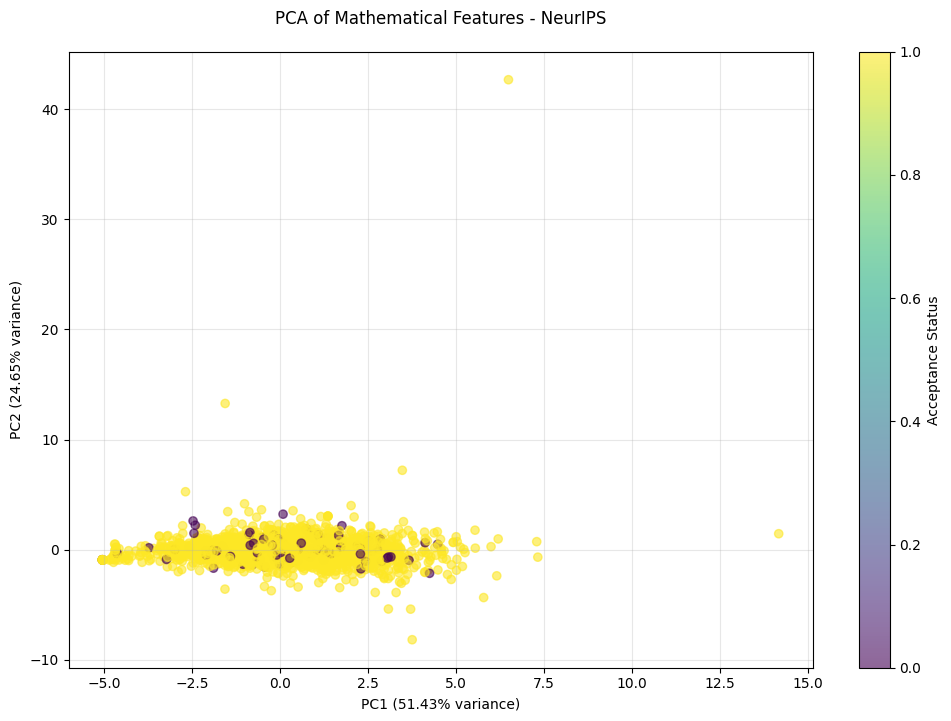


Analyzing feature interactions...

Feature Interaction Statistics:

num_equations vs mean_num_new_symbols_introduced:
Correlation coefficient: -0.204
Accepted papers (mean ± std):
- num_equations: 472.168 ± 479.930
- mean_num_new_symbols_introduced: 0.271 ± 0.636
Rejected papers (mean ± std):
- num_equations: 442.195 ± 378.014
- mean_num_new_symbols_introduced: 0.271 ± 0.270

num_equations vs num_overall_unique_symbols:
Correlation coefficient: 0.706
Accepted papers (mean ± std):
- num_equations: 472.168 ± 479.930
- num_overall_unique_symbols: 67.283 ± 32.078
Rejected papers (mean ± std):
- num_equations: 442.195 ± 378.014
- num_overall_unique_symbols: 67.456 ± 29.655

num_equations vs mean_num_unique_symbols:
Correlation coefficient: 0.153
Accepted papers (mean ± std):
- num_equations: 472.168 ± 479.930
- mean_num_unique_symbols: 3.260 ± 1.406
Rejected papers (mean ± std):
- num_equations: 442.195 ± 378.014
- mean_num_unique_symbols: 3.353 ± 1.333

num_equations vs std_of_unique_symb

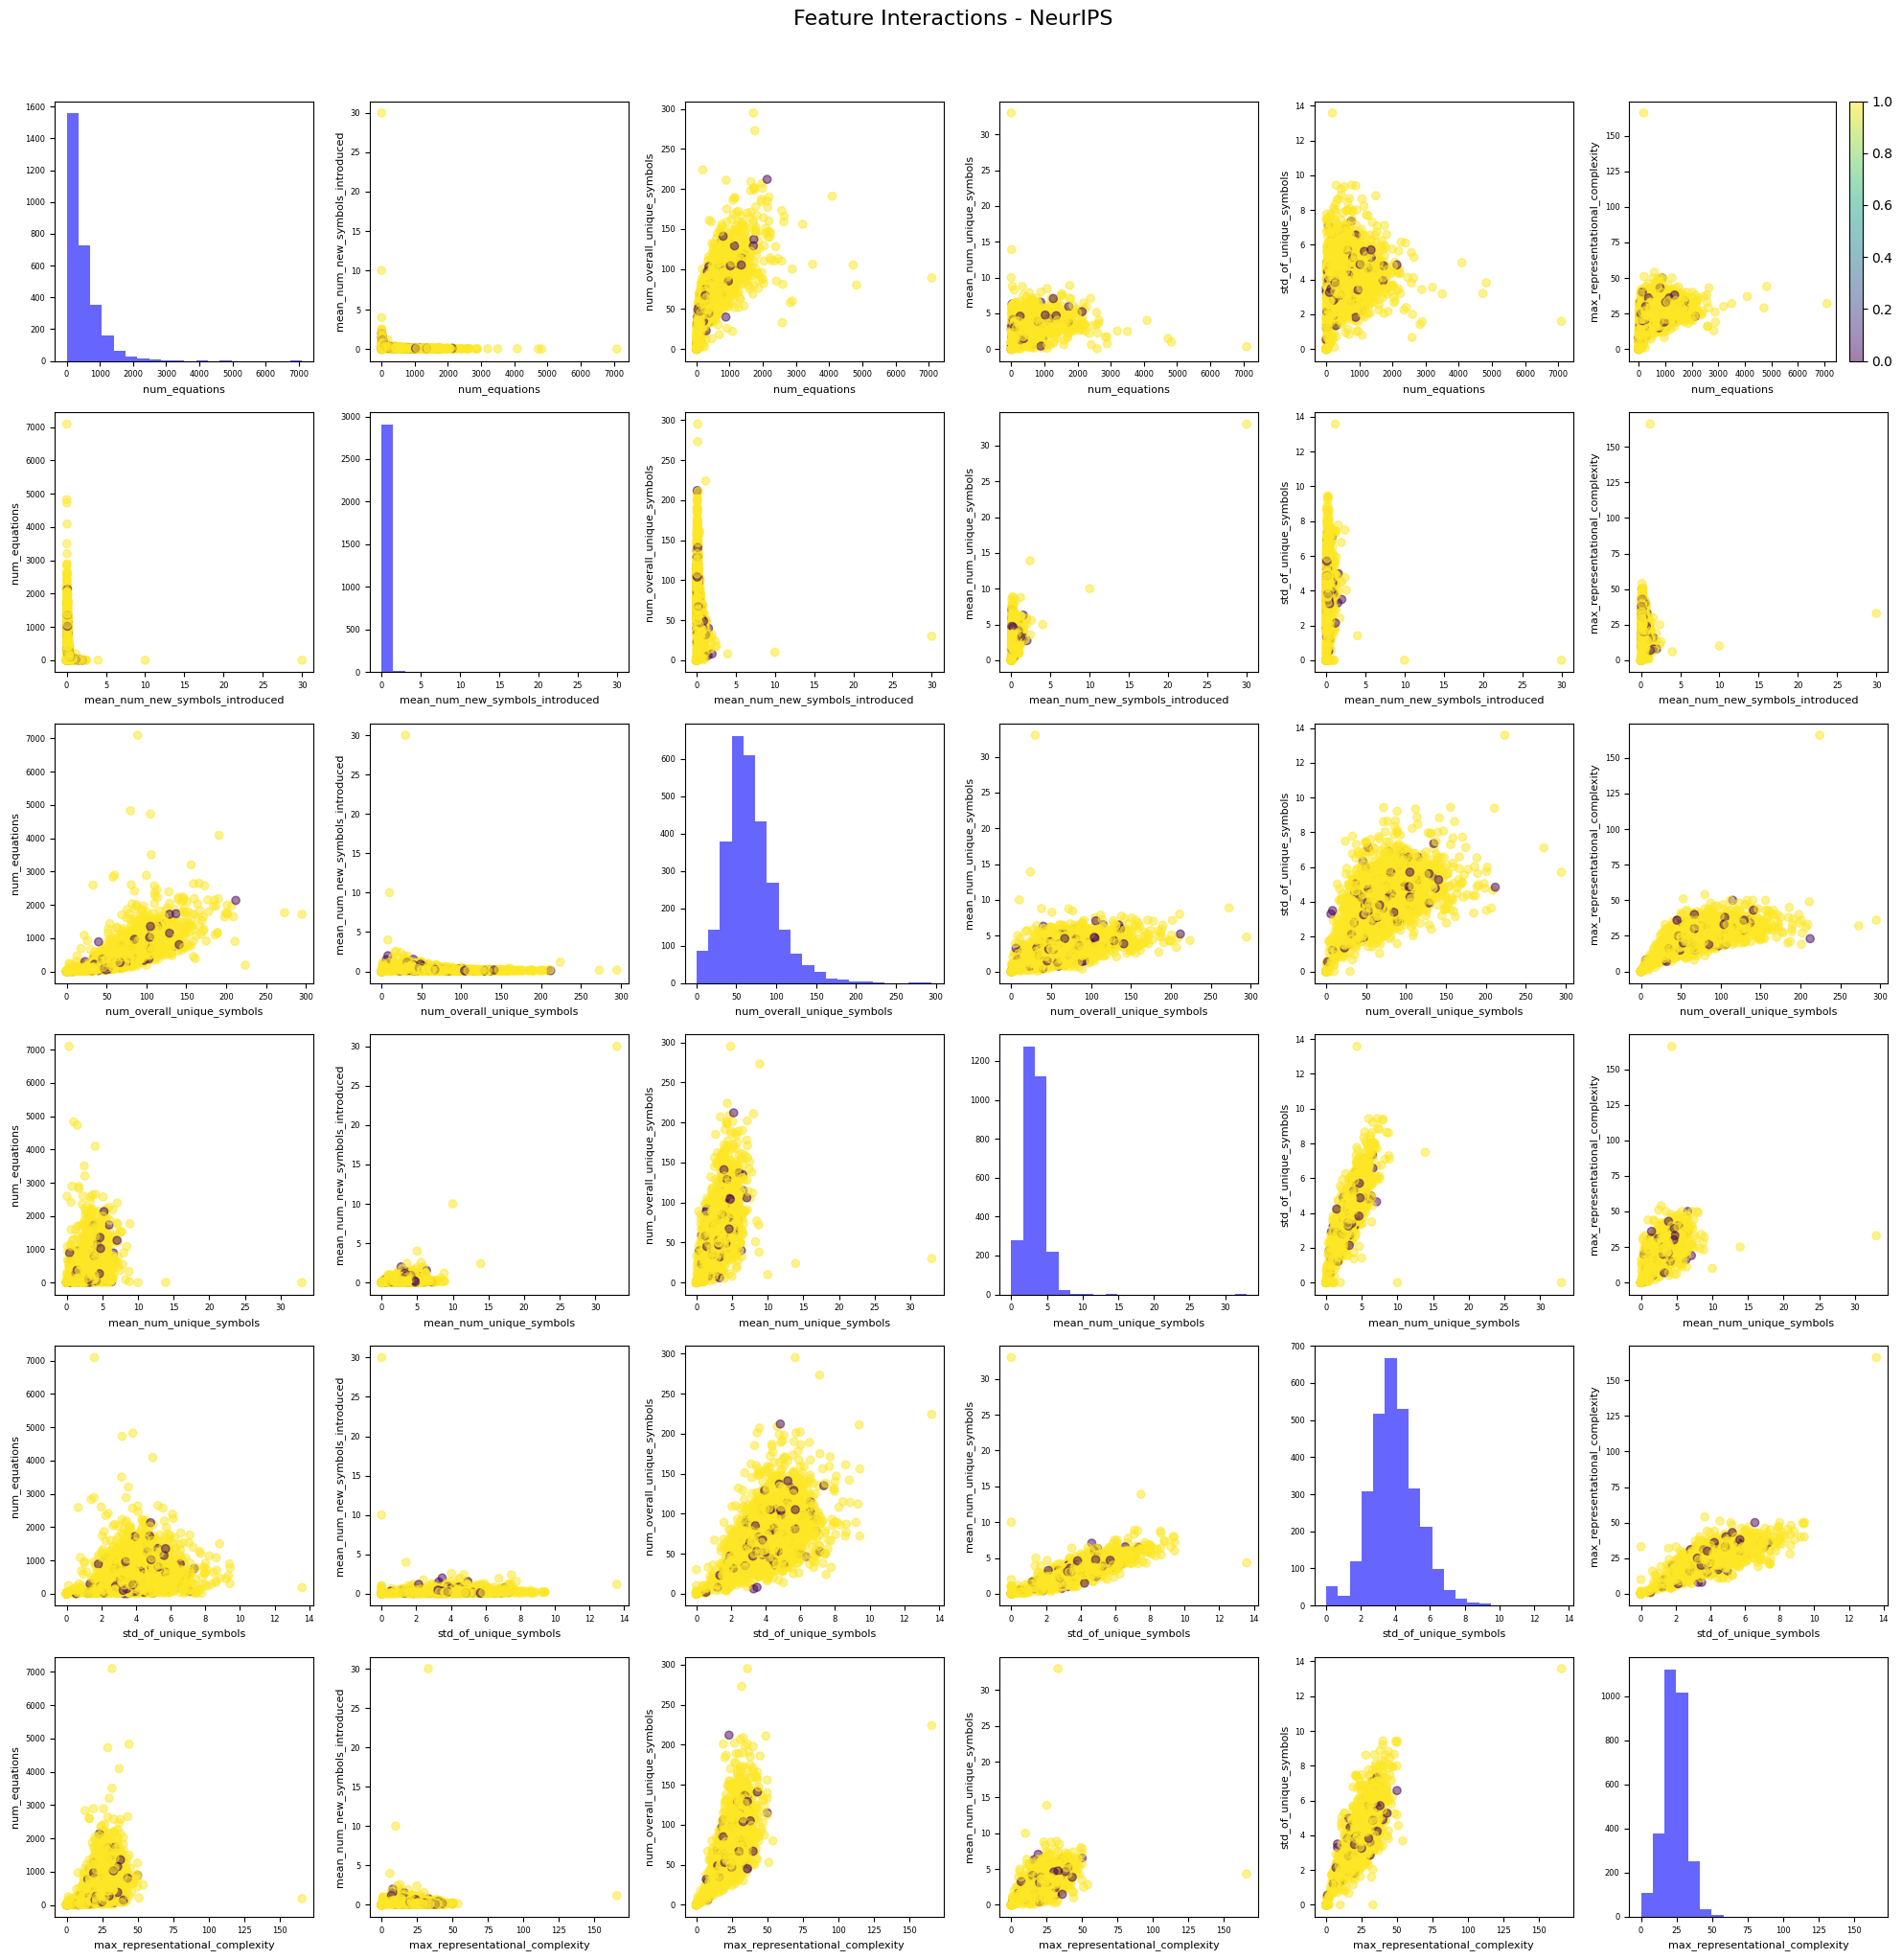


Training and evaluating models...

Detailed Model Performance Results for NeurIPS Model Performance

Accuracy:
--------------------------------------------------

Regular Models:
Model                      Mean        Std
------------------------------------------
Always Accept             0.946      0.009
LogisticRegression        0.946      0.009
SVM Linear                0.946      0.009
SVM RBF                   0.946      0.009
Random Forest             0.945      0.008
Gradient Boosting         0.943      0.008
XGBoost                   0.941      0.009
Neural Network            0.941      0.011
Decision Tree             0.895      0.012
Random Guess              0.504      0.008
Always Reject             0.054      0.009

SMOTEEN Models:
Model                      Mean        Std
------------------------------------------
Smoteen Always Accept      0.946      0.009
Smoteen XGBoost           0.776      0.017
Smoteen Neural Network      0.762      0.025
Smoteen Decision Tree     

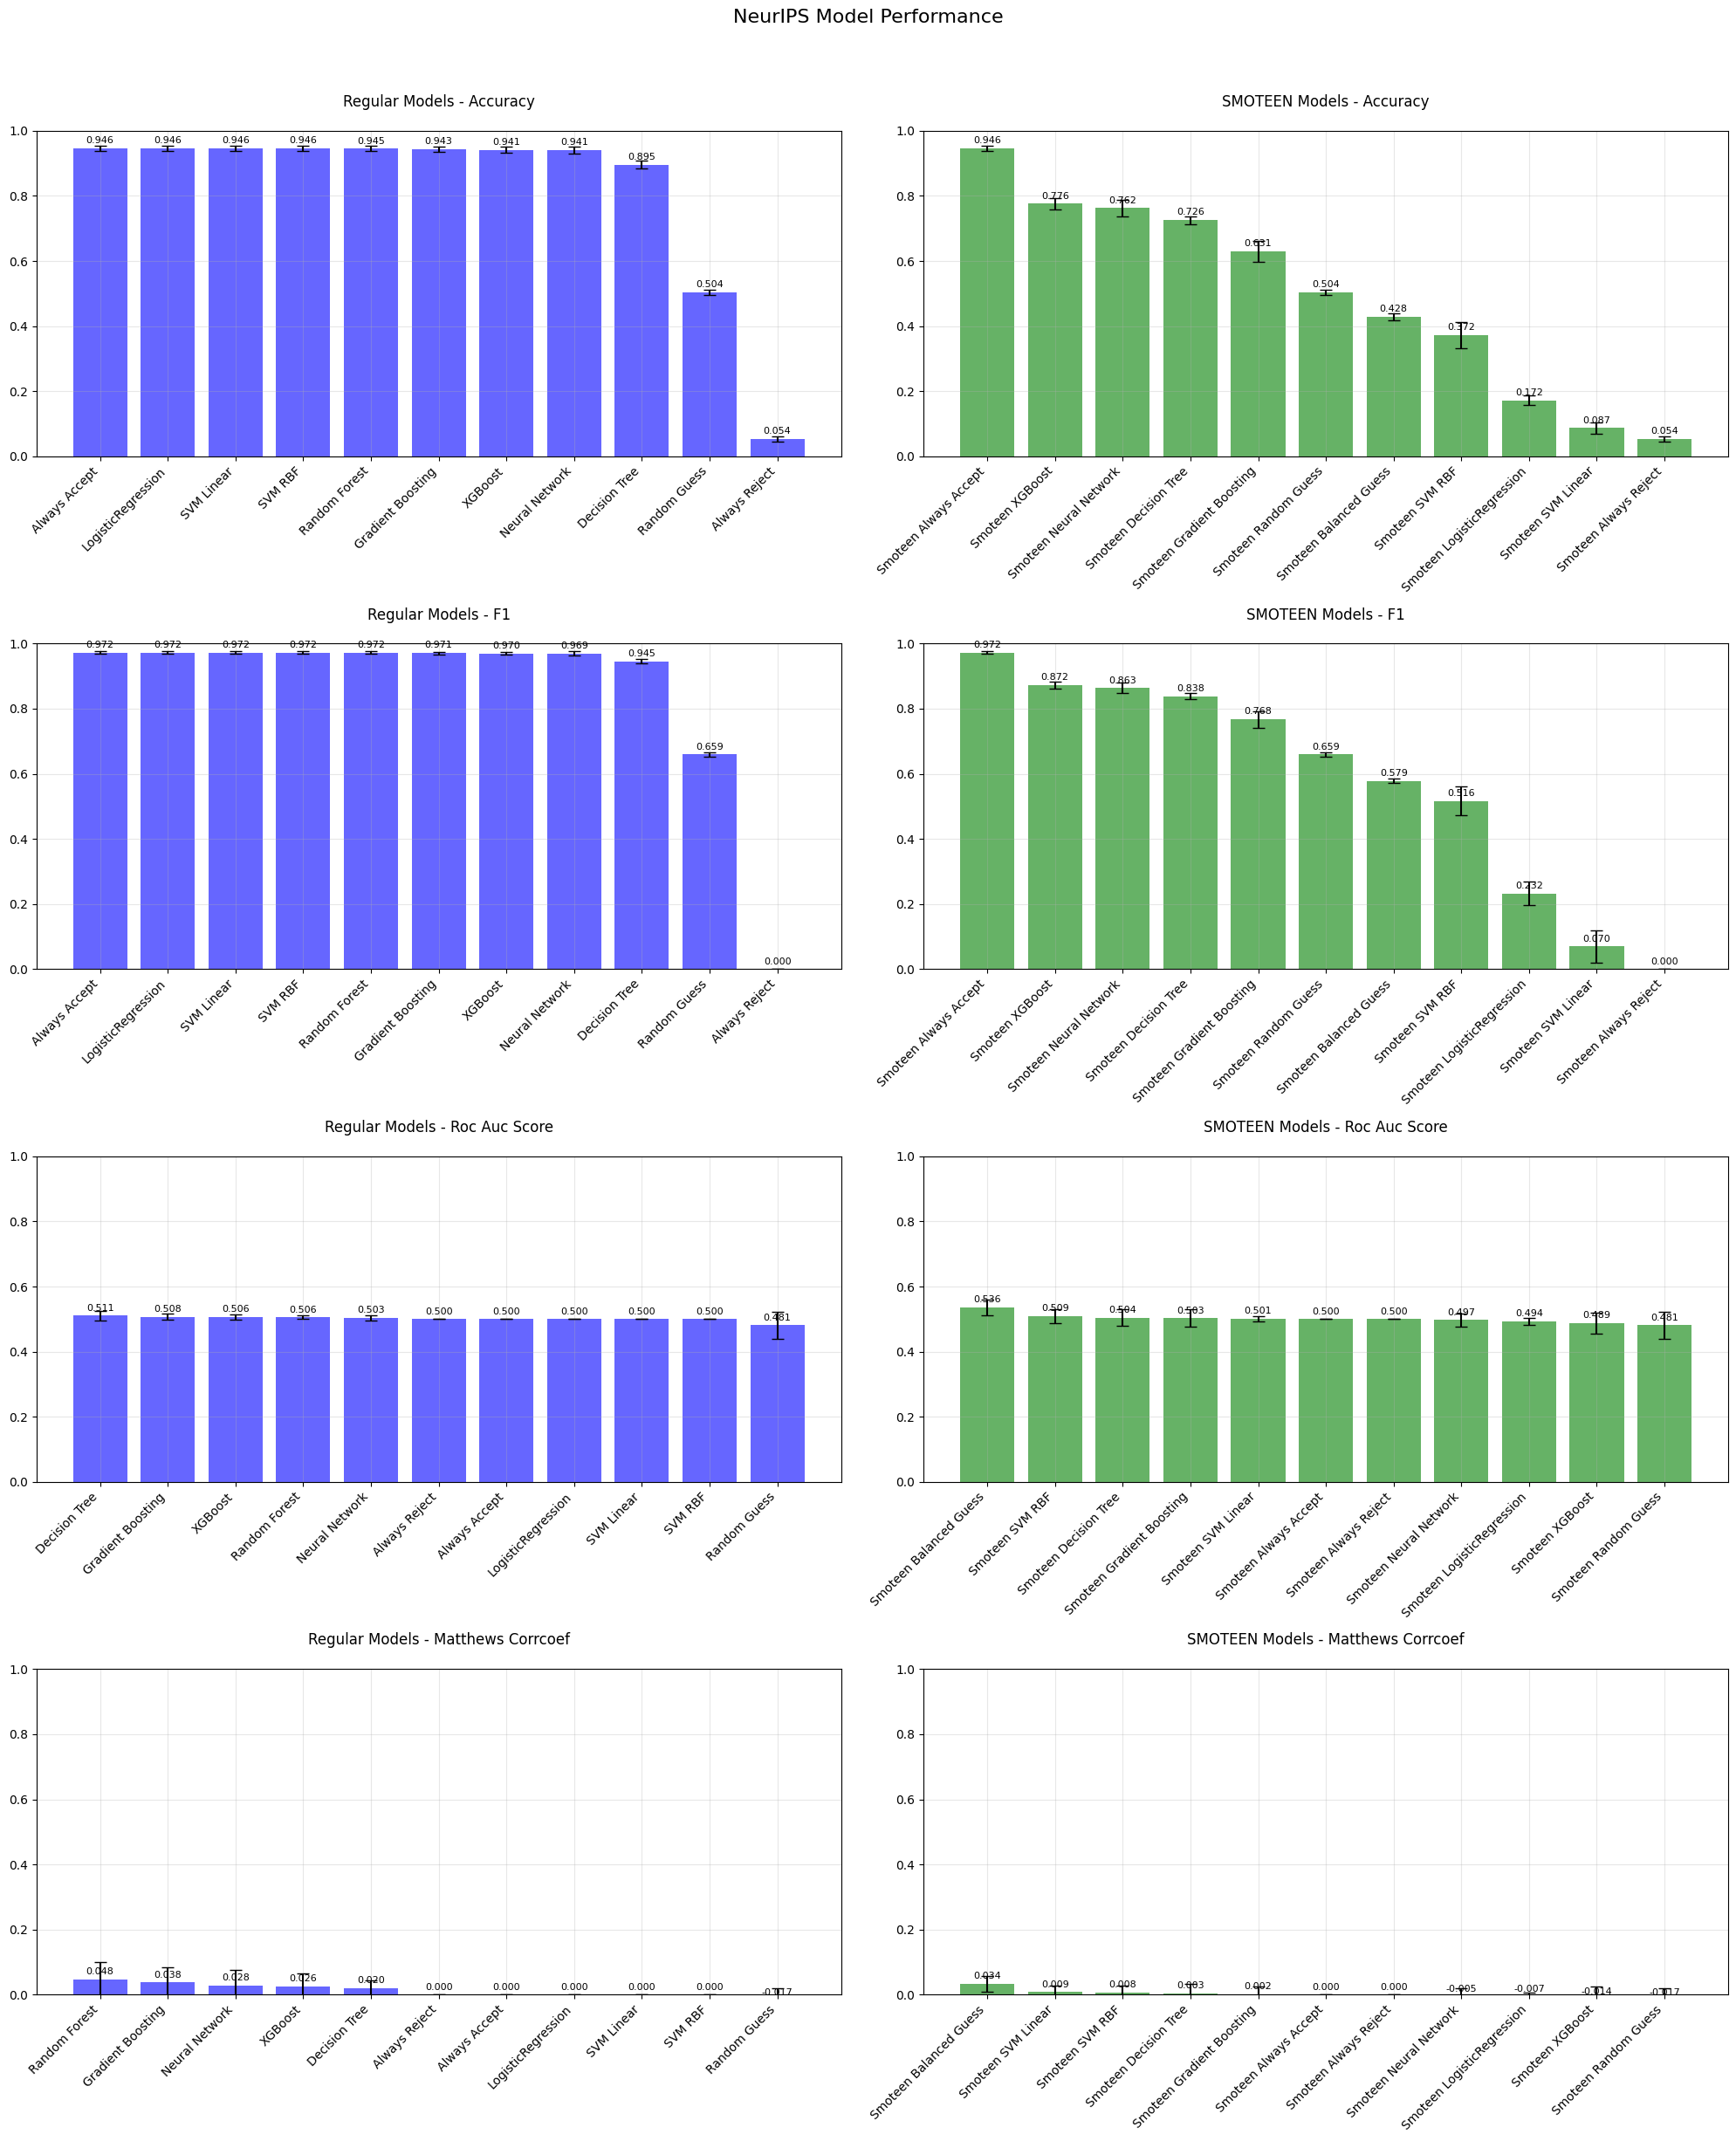


Best performing model: Smoteen Balanced Guess

Analyzing feature importance...

Feature Importance:
                        Feature  Importance  Std
                  num_equations         0.0  0.0
mean_num_new_symbols_introduced         0.0  0.0
     num_overall_unique_symbols         0.0  0.0
        mean_num_unique_symbols         0.0  0.0
          std_of_unique_symbols         0.0  0.0
max_representational_complexity         0.0  0.0




In [6]:
# Comprehensive Machine Learning Analysis
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from imblearn.combine import SMOTEENN
import xgboost as xgb
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.base import clone

# Machine Learning Analysis

def train_and_evaluate_models(X, y, random_state=42, n_runs=5):
    """Train and evaluate an expanded set of models with advanced configurations."""
    base_models = {
        # Baseline Models
        "Random Guess": DummyClassifier(strategy='uniform', random_state=random_state),
        "Always Reject": DummyClassifier(strategy='constant', constant=0),
        "Always Accept": DummyClassifier(strategy='constant', constant=1),
        
        # Linear Models
        "LogisticRegression": LogisticRegression(max_iter=50000, solver="lbfgs", random_state=random_state),
        
        # Tree-based Models
        "Decision Tree": DecisionTreeClassifier(random_state=random_state),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=random_state),
        "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
        "XGBoost": xgb.XGBClassifier(random_state=random_state),
        
        # Support Vector Machines
        "SVM Linear": SVC(kernel="linear", probability=True, random_state=random_state),
        "SVM RBF": SVC(kernel="rbf", probability=True, random_state=random_state),
        
        # Neural Networks
        "Neural Network": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=random_state)
    }
    
    # Add all models including SMOTEEN baselines
    all_models = {
        **base_models,
        "Smoteen Random Guess": DummyClassifier(strategy='uniform', random_state=random_state),
        "Smoteen Balanced Guess": DummyClassifier(strategy='stratified', random_state=random_state),
        "Smoteen Always Accept": DummyClassifier(strategy='constant', constant=1),
        "Smoteen Always Reject": DummyClassifier(strategy='constant', constant=0)
    }
    
    # Add SMOTEEN versions of non-baseline models
    for name, model in base_models.items():
        if not name.startswith(("Random", "Always")):
            all_models[f"Smoteen {name}"] = clone(model)
    
    results = {name: {metric: [] for metric in ['accuracy', 'f1', 'roc_auc_score', 'matthews_corrcoef']}
              for name in all_models.keys()}
    
    # Initialize trained_models with clones of the initial models
    trained_models = {name: clone(model) for name, model in all_models.items()}
    
    smoteenn = SMOTEENN(random_state=random_state)
    best_scores = {name: -1 for name in all_models.keys()}
    
    for i in range(n_runs):
        run_seed = random_state + i
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=run_seed)
        
        # Normalize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create SMOTEEN version of training data
        X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train_scaled, y_train)
        
        for name, model in all_models.items():
            model_copy = clone(model)
            
            # Use appropriate training data based on model type
            if name.startswith("Smoteen"):
                X_train_current = X_train_resampled
                y_train_current = y_train_resampled
            else:
                X_train_current = X_train_scaled
                y_train_current = y_train
            
            # Train and evaluate
            model_copy.fit(X_train_current, y_train_current)
            y_pred = model_copy.predict(X_test_scaled)
            
            # Calculate and store metrics
            current_score = roc_auc_score(y_test, y_pred)
            results[name]['accuracy'].append(accuracy_score(y_test, y_pred))
            results[name]['f1'].append(f1_score(y_test, y_pred))
            results[name]['roc_auc_score'].append(current_score)
            results[name]['matthews_corrcoef'].append(matthews_corrcoef(y_test, y_pred))
            
            # Update best model if current performance is better
            if current_score > best_scores[name]:
                best_scores[name] = current_score
                trained_models[name] = clone(model_copy)
    
    return results, trained_models

def plot_model_comparison(results, title):
    """Plot model performance comparison with error bars, separating regular and SMOTEEN models."""
    metrics = ['accuracy', 'f1', 'roc_auc_score', 'matthews_corrcoef']
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 24))
    
    print(f"\nDetailed Model Performance Results for {title}")
    print("=" * 60)
    
    # Separate regular and SMOTEEN models
    regular_models = {k: v for k, v in results.items() if not k.startswith('Smoteen')}
    smoteen_models = {k: v for k, v in results.items() if k.startswith('Smoteen')}
    
    for idx, metric in enumerate(metrics):
        # Process regular models
        sorted_regular = sorted(regular_models.keys(),
                              key=lambda x: np.mean(regular_models[x][metric]),
                              reverse=True)
        
        # Process SMOTEEN models
        sorted_smoteen = sorted(smoteen_models.keys(),
                              key=lambda x: np.mean(smoteen_models[x][metric]),
                              reverse=True)
        
        # Print detailed results for this metric
        print(f"\n{metric.replace('_', ' ').title()}:")
        print("-" * 50)
        
        print("\nRegular Models:")
        print(f"{'Model':<20} {'Mean':>10} {'Std':>10}")
        print("-" * 42)
        for model in sorted_regular:
            mean = np.mean(results[model][metric])
            std = np.std(results[model][metric])
            print(f"{model:<20} {mean:>10.3f} {std:>10.3f}")
        
        print("\nSMOTEEN Models:")
        print(f"{'Model':<20} {'Mean':>10} {'Std':>10}")
        print("-" * 42)
        for model in sorted_smoteen:
            mean = np.mean(results[model][metric])
            std = np.std(results[model][metric])
            print(f"{model:<20} {mean:>10.3f} {std:>10.3f}")
        
        # Plot regular models
        ax_reg = axs[idx, 0]
        values_reg = [results[model][metric] for model in sorted_regular]
        means_reg = [np.mean(v) for v in values_reg]
        stds_reg = [np.std(v) for v in values_reg]
        
        x_pos = np.arange(len(sorted_regular))
        ax_reg.bar(x_pos, means_reg, color="blue", alpha=0.6)
        ax_reg.errorbar(x_pos, means_reg, yerr=stds_reg, fmt='none', color="black", capsize=5)
        
        ax_reg.set_xticks(x_pos)
        ax_reg.set_xticklabels(sorted_regular, rotation=45, ha='right')
        ax_reg.set_title(f"Regular Models - {metric.replace('_', ' ').title()}", pad=20, fontsize=12)
        ax_reg.set_ylim(0, 1)
        ax_reg.grid(True, alpha=0.3)
        
        for i, v in enumerate(means_reg):
            ax_reg.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)
        
        # Plot SMOTEEN models
        ax_smoteen = axs[idx, 1]
        values_smoteen = [results[model][metric] for model in sorted_smoteen]
        means_smoteen = [np.mean(v) for v in values_smoteen]
        stds_smoteen = [np.std(v) for v in values_smoteen]
        
        x_pos = np.arange(len(sorted_smoteen))
        ax_smoteen.bar(x_pos, means_smoteen, color="green", alpha=0.6)
        ax_smoteen.errorbar(x_pos, means_smoteen, yerr=stds_smoteen, fmt='none', color="black", capsize=5)
        
        ax_smoteen.set_xticks(x_pos)
        ax_smoteen.set_xticklabels(sorted_smoteen, rotation=45, ha='right')
        ax_smoteen.set_title(f"SMOTEEN Models - {metric.replace('_', ' ').title()}", pad=20, fontsize=12)
        ax_smoteen.set_ylim(0, 1)
        ax_smoteen.grid(True, alpha=0.3)
        
        for i, v in enumerate(means_smoteen):
            ax_smoteen.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    return fig

def perform_pca_analysis(X, y, title, n_components=2):
    """Perform PCA analysis and visualization."""
    pca = PCA(n_components=n_components)
    X_scaled = StandardScaler().fit_transform(X)
    X_pca = pca.fit_transform(X_scaled)
    
    # Print detailed PCA results
    print("\nPCA Analysis Results:")
    print("=" * 50)
    print("\nExplained Variance Ratio:")
    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i+1}: {ratio:.4f} ({ratio:.2%})")
    
    print("\nComponent Loadings:")
    print(f"{'Feature':<15} {'PC1':>10} {'PC2':>10}")
    print("-" * 37)
    for feature, loading in zip(FEATURE_NAMES, pca.components_.T):
        print(f"{feature:<15} {loading[0]:>10.3f} {loading[1]:>10.3f}")
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.colorbar(scatter, label='Acceptance Status')
    plt.title(title, pad=20)
    plt.grid(True, alpha=0.3)
    return pca

def perform_feature_interaction_analysis(X, y, feature_names, title):
    """Analyze pairwise feature interactions."""
    n_features = len(feature_names)
    fig, axes = plt.subplots(n_features, n_features, figsize=(20, 20))
    
    print("\nFeature Interaction Statistics:")
    print("=" * 50)
    
    for i in range(n_features):
        for j in range(n_features):
            if i != j:
                # Calculate correlation coefficient
                corr = np.corrcoef(X[:, i], X[:, j])[0, 1]
                print(f"\n{feature_names[i]} vs {feature_names[j]}:")
                print(f"Correlation coefficient: {corr:.3f}")
                
                # Calculate class-wise statistics
                accepted = y == 1
                rejected = y == 0
                print(f"Accepted papers (mean ± std):")
                print(f"- {feature_names[i]}: {np.mean(X[accepted, i]):.3f} ± {np.std(X[accepted, i]):.3f}")
                print(f"- {feature_names[j]}: {np.mean(X[accepted, j]):.3f} ± {np.std(X[accepted, j]):.3f}")
                print(f"Rejected papers (mean ± std):")
                print(f"- {feature_names[i]}: {np.mean(X[rejected, i]):.3f} ± {np.std(X[rejected, i]):.3f}")
                print(f"- {feature_names[j]}: {np.mean(X[rejected, j]):.3f} ± {np.std(X[rejected, j]):.3f}")
            
            # Create visualization
            ax = axes[i, j]
            if i != j:
                scatter = ax.scatter(X[:, i], X[:, j], c=y, cmap='viridis', alpha=0.5)
                ax.set_xlabel(feature_names[i], fontsize=8)
                ax.set_ylabel(feature_names[j], fontsize=8)
            else:
                ax.hist(X[:, i], bins=20, color='blue', alpha=0.6)
                ax.set_xlabel(feature_names[i], fontsize=8)
            ax.tick_params(axis='both', which='major', labelsize=6)
            
            if i == 0 and j == n_features-1:
                plt.colorbar(scatter, ax=ax)
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    return fig

def analyze_feature_importance(model, X_train, X_test, y_test, feature_names, n_repeats=10):
    """Analyze feature importance using permutation importance."""
    try:
        perm_importance = permutation_importance(model, X_test, y_test, 
                                               n_repeats=n_repeats, random_state=42)
        
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': perm_importance.importances_mean,
            'Std': perm_importance.importances_std
        })
        return importance_df.sort_values('Importance', ascending=False)
    except Exception as e:
        print(f"Could not compute permutation importance: {str(e)}")
        return None

# Run comprehensive analysis
RANDOM_STATE = 42
print("Performing comprehensive analysis...")

for conf_name, features, labels in [('ICLR', iclr_features, iclr_labels),
                                  ('NeurIPS', neurips_features, neurips_labels)]:
    print(f"\n{'='*20} {conf_name} Analysis {'='*20}")
    
    # Split data once for consistent analysis
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.3, random_state=RANDOM_STATE
    )
    
    # PCA Analysis
    print("\nPerforming PCA analysis...")
    pca = perform_pca_analysis(features, labels, f'PCA of Mathematical Features - {conf_name}')
    print(f"Explained variance ratio: PC1={pca.explained_variance_ratio_[0]:.2%}, "
          f"PC2={pca.explained_variance_ratio_[1]:.2%}")
    plt.show()
    
    # Feature Interactions
    print("\nAnalyzing feature interactions...")
    interaction_fig = perform_feature_interaction_analysis(
        features.values, labels, FEATURE_NAMES, f'Feature Interactions - {conf_name}'
    )
    plt.show()
    
    # Model Training and Evaluation
    print("\nTraining and evaluating models...")
    results, trained_models = train_and_evaluate_models(features, labels, random_state=RANDOM_STATE)
    
    # Plot model comparison
    fig = plot_model_comparison(results, f"{conf_name} Model Performance")
    plt.show()
    
    # Get best model and fit it on the full training data
    best_model_name = max(results.items(), key=lambda x: np.mean(x[1]['roc_auc_score']))[0]
    best_model = trained_models[best_model_name]
    
    print(f"\nBest performing model: {best_model_name}")
    
    # Feature importance analysis
    print("\nAnalyzing feature importance...")
    
    # Refit the best model on the training data before computing importance
    try:
        X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
            features, labels, test_size=0.3, random_state=RANDOM_STATE
        )
        
        # Scale the data
        scaler_final = StandardScaler()
        X_train_final_scaled = scaler_final.fit_transform(X_train_final)
        X_test_final_scaled = scaler_final.transform(X_test_final)
        
        # If it's a SMOTEENN model, apply SMOTEENN first
        if best_model_name.startswith("Smoteen"):
            smoteenn_final = SMOTEENN(random_state=RANDOM_STATE)
            X_train_final_scaled, y_train_final = smoteenn_final.fit_resample(
                X_train_final_scaled, y_train_final
            )
        
        # Fit the model
        best_model.fit(X_train_final_scaled, y_train_final)
        
        # Now compute feature importance
        importance_df = analyze_feature_importance(
            best_model, X_train_final_scaled, X_test_final_scaled, 
            y_test_final, FEATURE_NAMES
        )
        if importance_df is not None:
            print("\nFeature Importance:")
            print(importance_df.to_string(index=False))
            
    except Exception as e:
        print(f"Could not compute feature importance: {str(e)}")

    print(f"\n{'='*50}\n")

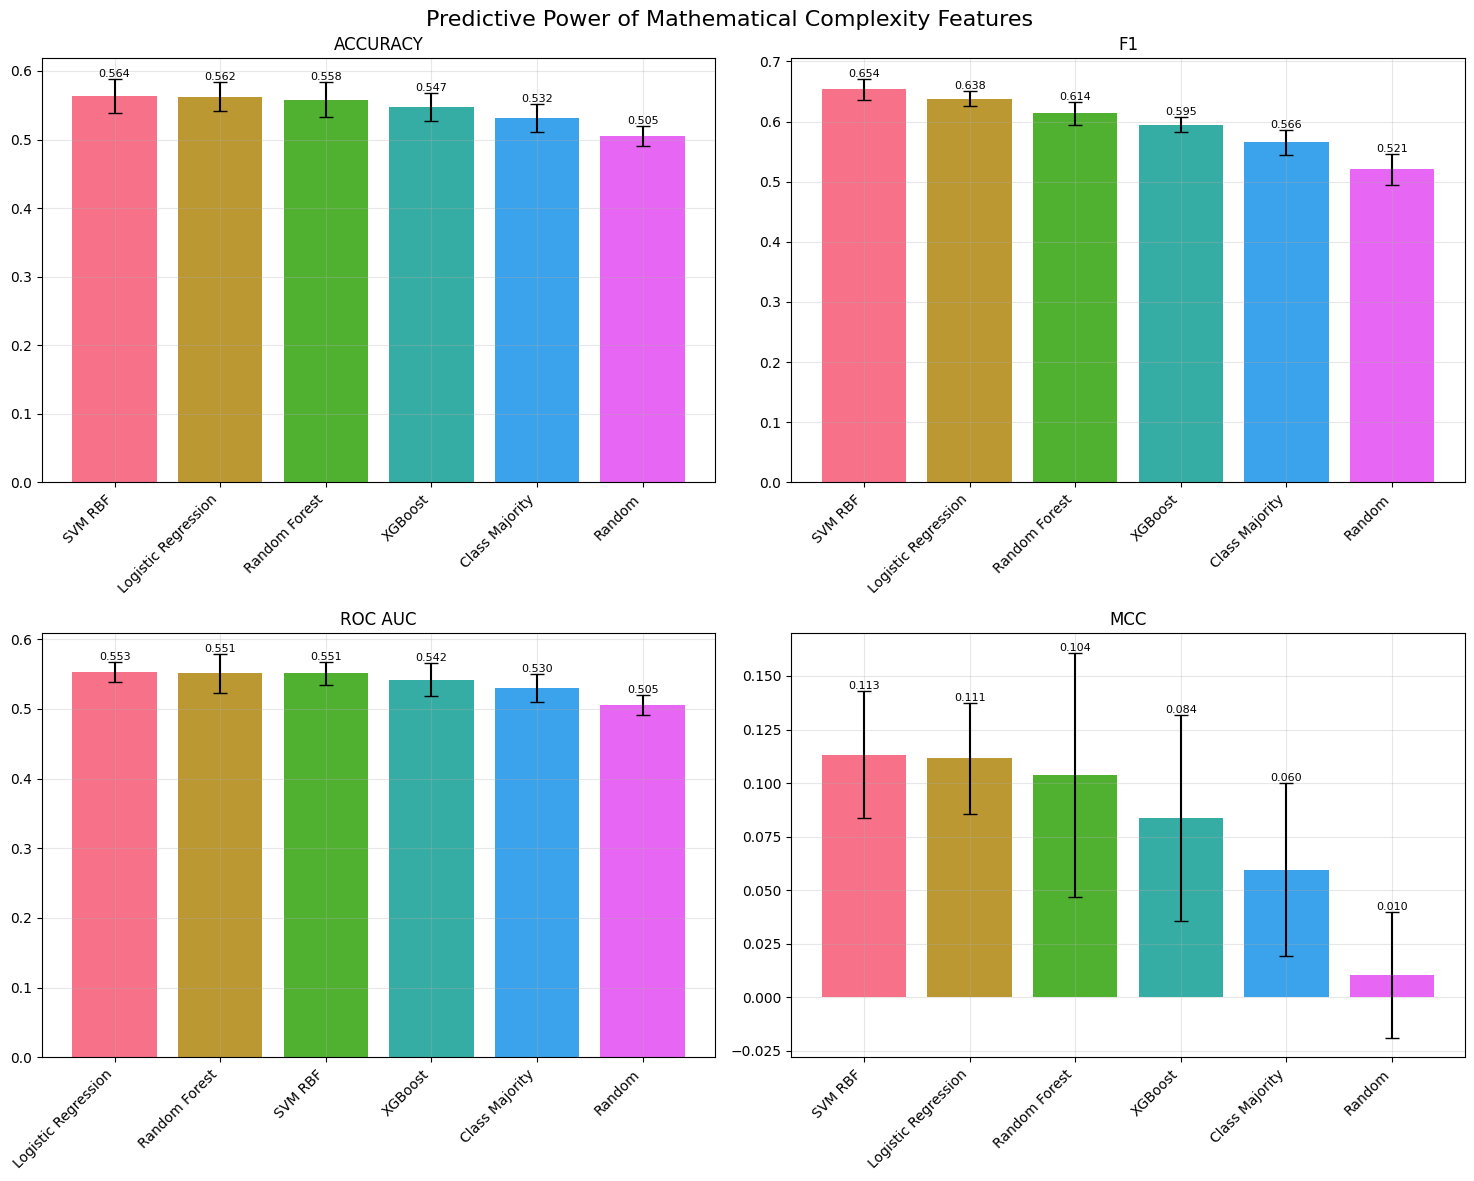

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_models(X, y, random_state=42, n_runs=5):
    """
    Train and evaluate models to assess predictive power of mathematical complexity features.
    We use multiple models to ensure our conclusions about predictive power are robust.
    """
    models = {
        # Baseline Models
        "Random": DummyClassifier(strategy='uniform', random_state=random_state),
        "Class Majority": DummyClassifier(strategy='stratified', random_state=random_state),
        
        # Prediction Models - each offering a different approach to finding patterns
        "Logistic Regression": LogisticRegression(random_state=random_state),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=random_state),
        "SVM RBF": SVC(kernel="rbf", probability=True, random_state=random_state),
        "XGBoost": xgb.XGBClassifier(random_state=random_state)
    }
    
    results = {name: {metric: [] for metric in ['accuracy', 'f1', 'roc_auc', 'mcc']}
              for name in models.keys()}
    
    for i in range(n_runs):
        # Use different random splits to ensure robust performance estimation
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=random_state+i
        )
        
        # Scale features to ensure fair model comparison
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        for name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            
            # Store multiple metrics to get a complete picture of predictive power
            results[name]['accuracy'].append(accuracy_score(y_test, y_pred))
            results[name]['f1'].append(f1_score(y_test, y_pred))
            results[name]['roc_auc'].append(roc_auc_score(y_test, y_pred))
            results[name]['mcc'].append(matthews_corrcoef(y_test, y_pred))
    
    return results

def plot_model_performance(results):
    """
    Create a clear visualization of model predictive performance.
    Shows all metrics to give a complete picture of how well we can predict acceptance.
    """
    metrics = ['accuracy', 'f1', 'roc_auc', 'mcc']
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        
        # Sort models by performance for clearer visualization
        sorted_models = sorted(results.keys(),
                             key=lambda x: np.mean(results[x][metric]),
                             reverse=True)
        
        means = [np.mean(results[model][metric]) for model in sorted_models]
        stds = [np.std(results[model][metric]) for model in sorted_models]
        
        # Create bars with error bars to show performance stability
        bars = ax.bar(range(len(sorted_models)), means, 
                     yerr=stds, capsize=5,
                     color=sns.color_palette("husl", len(sorted_models)))
        
        ax.set_xticks(range(len(sorted_models)))
        ax.set_xticklabels(sorted_models, rotation=45, ha='right')
        ax.set_title(f'{metric.replace("_", " ").upper()}')
        ax.grid(True, alpha=0.3)
        
        # Add value labels
        for i, v in enumerate(means):
            ax.text(i, v + stds[i], f'{v:.3f}', 
                   ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('Predictive Power of Mathematical Complexity Features', fontsize=16)
    plt.tight_layout()
    return fig

# Run the analysis
results = train_and_evaluate_models(iclr_features, iclr_labels)

# Visualize results
fig = plot_model_performance(results)
plt.show()